# ML vs non-ML Pylint Exploration

Dependencies:
- histograms-sel notebook (`ds_selected.csv`, `nonds_selected.csv`)
- analyse_imports notebook (`proj_labels.csv`)
- analyse_py_ver notebook (`ds_version_tab.csv`, `nonds_version_tab.csv`)

Inputs:
* `results_pylint_python3.csv`

This notebook:

- Normalises the number of Pylint Errors based on the number of non-blank LOC
- Visualises the results for each type of Pylint Error/Warning, broken down by category (ML0, ML1, ML2, ML3, ML4)
- Visualises the results for each type of Pylint Error/Warning, broken down by DS/non-DS
- Ranks Pylint Errors/Warnings by the significance of the difference between DS/non-DS repos


In [1]:
from os.path import join
import pandas as pd
import numpy as np
import altair as alt
from altair import datum
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "../output/"
NB_OUT = join(DATA_DIR, "notebooks_out")
MERGED_DIR = join(DATA_DIR, "merged")

In [3]:
# https://altair-viz.github.io/user_guide/faq.html#altair-faq-large-notebook
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## Load Pylint Results

In [4]:
lint_df_py3 = pd.read_csv(join(MERGED_DIR, "results_pylint_python3.csv"))

/home/anj/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
lint_df_py3

,repo,path,type,module,obj,line,column,path.1,symbol,message,message-id,parse_error,internal_error
0,190000321,190000321/setup.py,convention,setup,NaN,36.0,27.0,setup.py,bad-whitespace,Exactly one space required after comma\n in...,C0326,False,False
1,190000321,190000321/setup.py,convention,setup,NaN,1.0,0.0,setup.py,missing-module-docstring,Missing module docstring,C0114,False,False
2,190000321,190000321/setup.py,warning,setup,NaN,2.0,0.0,setup.py,redefined-builtin,Redefining built-in 'open',W0622,False,False
3,190000321,190000321/setup.py,convention,setup,NaN,5.0,0.0,setup.py,invalid-name,"Constant name ""here"" doesn't conform to UPPER_...",C0103,False,False
4,190000321,190000321/setup.py,convention,setup,NaN,9.0,4.0,setup.py,invalid-name,"Constant name ""long_description"" doesn't confo...",C0103,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15227162,38355280,38355280/lib/core/exceptions.py,warning,lib.core.exceptions,FlashLightExceptions.__init__,4.0,8.0,lib/core/exceptions.py,super-init-not-called,__init__ method from base class 'Exception' is...,W0231,False,False
15227163,38355280,38355280/lib/core/core.py,error,lib.core.core,NaN,35.0,21.0,lib/core/core.py,syntax-error,inconsistent use of tabs and spaces in indenta...,E0001,True,False
15227164,38347270,38347270/main.py,error,main,NaN,72.0,34.0,main.py,syntax-error,Missing parentheses in call to 'print'. Did yo...,E0001,True,False
15227165,38347270,38347270/.buildozer/android/app/main.py,error,main,NaN,72.0,34.0,.buildozer/android/app/main.py,syntax-error,Missing parentheses in call to 'print'. Did yo...,E0001,True,False


In [6]:
ds_selected = set(pd.read_csv(join(NB_OUT, "ds_selected.csv"))['id'])

In [7]:
nonds_selected = set(pd.read_csv(join(NB_OUT, "nonds_selected.csv"))['id'])

In [8]:
py3_repos = ds_selected | nonds_selected

## Remove Files with Parse Errors from Analysis

In [9]:
# We only analyse Python 3 repos. Furthermore, we limit to the selected set of repos
lint_df_combo = lint_df_py3[lint_df_py3.repo.isin(py3_repos)]

In [10]:
len(set(lint_df_combo.repo.unique()) & nonds_selected)

1102

In [11]:
lint_df_combo.parse_error.value_counts()

False    6303113
True        6279
Name: parse_error, dtype: int64

In [12]:
print(sorted(filter(lambda x: not pd.isnull(x), lint_df_combo["message-id"].unique())))

['C0102', 'C0103', 'C0112', 'C0113', 'C0114', 'C0115', 'C0116', 'C0121', 'C0122', 'C0123', 'C0200', 'C0201', 'C0202', 'C0203', 'C0204', 'C0205', 'C0301', 'C0302', 'C0303', 'C0304', 'C0305', 'C0321', 'C0325', 'C0326', 'C0327', 'C0330', 'C0410', 'C0411', 'C0412', 'C0413', 'C0414', 'C0415', 'C1801', 'E0001', 'E0011', 'E0012', 'E0101', 'E0102', 'E0107', 'E0108', 'E0110', 'E0111', 'E0117', 'E0118', 'E0119', 'E0202', 'E0203', 'E0211', 'E0213', 'E0236', 'E0237', 'E0238', 'E0239', 'E0240', 'E0242', 'E0301', 'E0302', 'E0303', 'E0401', 'E0402', 'E0601', 'E0602', 'E0603', 'E0604', 'E0611', 'E0633', 'E0701', 'E0702', 'E0703', 'E0704', 'E0710', 'E0711', 'E0712', 'E1003', 'E1101', 'E1102', 'E1111', 'E1120', 'E1121', 'E1123', 'E1124', 'E1125', 'E1126', 'E1128', 'E1129', 'E1130', 'E1132', 'E1133', 'E1134', 'E1135', 'E1136', 'E1137', 'E1138', 'E1139', 'E1141', 'E1200', 'E1205', 'E1206', 'E1300', 'E1301', 'E1303', 'E1305', 'E1306', 'E1307', 'E1310', 'E1701', 'F0001', 'F0002', 'F0010', 'I1101', 'R0123', 

In [13]:
lint_df_combo[lint_df_combo["parse_error"]].repo.value_counts()

97159209     3155
103329709     755
94794236      682
88868842      384
86715491      226
             ... 
21103726        1
32320647        1
126856423       1
72246634        1
60723336        1
Name: repo, Length: 106, dtype: int64

In [14]:
lint_df_combo[lint_df_combo["parse_error"]]

,repo,path,type,module,obj,line,column,path.1,symbol,message,message-id,parse_error,internal_error
47418,155730079,155730079/8_3_Value_Network.py,error,8_3_Value_Network,NaN,20.0,1.0,8_3_Value_Network.py,syntax-error,"invalid syntax (&lt;unknown&gt;, line 20)",E0001,True,False
67174,153597157,153597157/blueoil/templates/lmnet/object_detec...,error,object_detection.tpl,NaN,20.0,40.0,blueoil/templates/lmnet/object_detection.tpl.py,syntax-error,"invalid syntax (&lt;unknown&gt;, line 20)",E0001,True,False
67175,153597157,153597157/blueoil/templates/lmnet/semantic_seg...,error,semantic_segmentation.tpl,NaN,33.0,2.0,blueoil/templates/lmnet/semantic_segmentation....,syntax-error,"invalid syntax (&lt;unknown&gt;, line 33)",E0001,True,False
67176,153597157,153597157/blueoil/templates/lmnet/classificati...,error,classification.tpl,NaN,20.0,38.0,blueoil/templates/lmnet/classification.tpl.py,syntax-error,"invalid syntax (&lt;unknown&gt;, line 20)",E0001,True,False
67177,153597157,153597157/blueoil/templates/lmnet/keypoint_det...,error,keypoint_detection.tpl,NaN,20.0,42.0,blueoil/templates/lmnet/keypoint_detection.tpl.py,syntax-error,"invalid syntax (&lt;unknown&gt;, line 20)",E0001,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10886963,48904888,48904888/redbot/cogs/mod/kickban.py,refactor,redbot.cogs.mod.kickban,KickBanMixin.voicekick,541.0,8.0,redbot/cogs/mod/kickban.py,no-else-return,"Unnecessary ""elif"" after ""return""",R1705,True,False
10886964,48904888,48904888/redbot/cogs/mod/kickban.py,convention,redbot.cogs.mod.kickban,KickBanMixin.voicekick,577.0,12.0,redbot/cogs/mod/kickban.py,invalid-name,"Variable name ""e"" doesn't conform to snake_cas...",C0103,True,False
10886965,48904888,48904888/redbot/cogs/mod/kickban.py,convention,redbot.cogs.mod.kickban,KickBanMixin.unban,619.0,12.0,redbot/cogs/mod/kickban.py,invalid-name,"Variable name ""e"" doesn't conform to snake_cas...",C0103,True,False
10886966,48904888,48904888/redbot/cogs/mod/kickban.py,warning,redbot.cogs.mod.kickban,KickBanMixin.unban,600.0,8.0,redbot/cogs/mod/kickban.py,unused-variable,Unused variable 'queue_entry',W0612,True,False


These are invalid python files, e.g. https://github.com/blue-oil/blueoil/blob/master/blueoil/templates/lmnet/semantic_segmentation.tpl.py

The "parse_error" column we create represents syntax errors (E0001). In some cases, the error can be triggered due to syntax errors in imported modules rather than the file itself.
We will remove these files from the analysis (including cases triggered by an import), as because if there is a syntax error, Pylint is usually unable to analyse the file any further. (If the syntax error is in an imported module, Pylint can continue, but will not be able to check usage of that module in the same depth).

In [15]:
lint_df_combo[lint_df_combo["symbol"] == "parse-error"]

,repo,path,type,module,obj,line,column,path.1,symbol,message,message-id,parse_error,internal_error
1635595,97159209,97159209/Math_Tutorials/Riemannian_Geometry_ML...,fatal,Riemannian_Geometry_ML_DL_Applications.4. PDM ...,NaN,1.0,0.0,Math_Tutorials/Riemannian_Geometry_ML_DL_Appli...,parse-error,error while code parsing: Unable to load file ...,F0010,False,False
1635605,97159209,97159209/Math_Tutorials/Riemannian_Geometry_ML...,fatal,Riemannian_Geometry_ML_DL_Applications.1. Baye...,NaN,1.0,0.0,Math_Tutorials/Riemannian_Geometry_ML_DL_Appli...,parse-error,error while code parsing: Unable to load file ...,F0010,False,False
2328543,82463827,82463827/tensorflow-program/rnn/stock_predict/...,fatal,stock_predict,NaN,1.0,0.0,tensorflow-program/rnn/stock_predict/stock_pre...,parse-error,error while code parsing: Wrong or no encoding...,F0010,False,False


Pylint also has a "parse-error" symbol which means that it couldn't read the file at all. These are all of type "fatal" 

In [16]:
lint_df_combo[lint_df_combo["type"] == "fatal"]

,repo,path,type,module,obj,line,column,path.1,symbol,message,message-id,parse_error,internal_error
1635595,97159209,97159209/Math_Tutorials/Riemannian_Geometry_ML...,fatal,Riemannian_Geometry_ML_DL_Applications.4. PDM ...,NaN,1.0,0.0,Math_Tutorials/Riemannian_Geometry_ML_DL_Appli...,parse-error,error while code parsing: Unable to load file ...,F0010,False,False
1635605,97159209,97159209/Math_Tutorials/Riemannian_Geometry_ML...,fatal,Riemannian_Geometry_ML_DL_Applications.1. Baye...,NaN,1.0,0.0,Math_Tutorials/Riemannian_Geometry_ML_DL_Appli...,parse-error,error while code parsing: Unable to load file ...,F0010,False,False
1655505,97159209,97159209/tensorflow_dl_models/research/cogniti...,fatal,cognitive_mapping_and_planning.datasets.nav_env,NaN,1.0,0.0,tensorflow_dl_models/research/cognitive_mappin...,astroid-error,&lt;class 'astroid.exceptions.InconsistentMroE...,F0002,False,True
2328543,82463827,82463827/tensorflow-program/rnn/stock_predict/...,fatal,stock_predict,NaN,1.0,0.0,tensorflow-program/rnn/stock_predict/stock_pre...,parse-error,error while code parsing: Wrong or no encoding...,F0010,False,False
3262672,59878622,59878622/lib/python2.7/fnmatch.py,fatal,lib/python2.7/fnmatch.py,NaN,1.0,0.0,lib/python2.7/fnmatch.py,fatal,No module named lib/python2.7/fnmatch.py,F0001,False,False
3262673,59878622,59878622/lib/python2.7/locale.py,fatal,lib/python2.7/locale.py,NaN,1.0,0.0,lib/python2.7/locale.py,fatal,No module named lib/python2.7/locale.py,F0001,False,False
3262674,59878622,59878622/lib/python2.7/linecache.py,fatal,lib/python2.7/linecache.py,NaN,1.0,0.0,lib/python2.7/linecache.py,fatal,No module named lib/python2.7/linecache.py,F0001,False,False
3262675,59878622,59878622/lib/python2.7/sre_compile.py,fatal,lib/python2.7/sre_compile.py,NaN,1.0,0.0,lib/python2.7/sre_compile.py,fatal,No module named lib/python2.7/sre_compile.py,F0001,False,False
3262676,59878622,59878622/lib/python2.7/_weakrefset.py,fatal,lib/python2.7/_weakrefset.py,NaN,1.0,0.0,lib/python2.7/_weakrefset.py,fatal,No module named lib/python2.7/_weakrefset.py,F0001,False,False
3262677,59878622,59878622/lib/python2.7/abc.py,fatal,lib/python2.7/abc.py,NaN,1.0,0.0,lib/python2.7/abc.py,fatal,No module named lib/python2.7/abc.py,F0001,False,False


In [17]:
lint_df_combo.internal_error.value_counts()

False    5894233
True      415159
Name: internal_error, dtype: int64

In [18]:
lint_df_combo[lint_df_combo["internal_error"]].repo.value_counts()

65847289     409684
123303402      4827
94247908        609
71486542          8
55973114          8
58056458          6
50232641          3
72084173          1
64710850          1
111113343         1
45234875          1
71932349          1
97159209          1
51117837          1
61130280          1
72582690          1
104973687         1
36914478          1
60601380          1
20734770          1
48904888          1
Name: repo, dtype: int64

In [19]:
lint_df_combo[lint_df_combo["internal_error"]]

,repo,path,type,module,obj,line,column,path.1,symbol,message,message-id,parse_error,internal_error
1248143,111113343,111113343/tests/test_dsl_skill.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
1655505,97159209,97159209/tensorflow_dl_models/research/cogniti...,fatal,cognitive_mapping_and_planning.datasets.nav_env,NaN,1.0,0.0,tensorflow_dl_models/research/cognitive_mappin...,astroid-error,&lt;class 'astroid.exceptions.InconsistentMroE...,F0002,False,True
2846838,72582690,72582690/extensions.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
2928993,72084173,72084173/deepnlp/.___init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
2944242,71932349,71932349/python/ray/cloudpickle/cloudpickle.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9496509,55973114,55973114/Resource/7th-Python-Solution/__MACOSX...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
10463357,50232641,50232641/ouroboros/test/badsyntax_pep3120.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
10506328,50232641,50232641/ouroboros/test/bad_coding2.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True
10515087,50232641,50232641/ouroboros/test/bad_coding.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True


The "internal error" column represents cases where the Pylint output was not valid JSON, or there was a message on stderr (e.g. because Pylint crashed - inspect the corresponding debug logs for details)

In [20]:
lint_df_combo[lint_df_combo["repo"] == 65847289]

,repo,path,type,module,obj,line,column,path.1,symbol,message,message-id,parse_error,internal_error
7971191,65847289,65847289/setup.py,warning,setup,NaN,39.0,2.0,setup.py,fixme,TODO: put package test requirements here,W0511,False,True
7971192,65847289,65847289/setup.py,convention,setup,NaN,1.0,0.0,setup.py,missing-module-docstring,Missing module docstring,C0114,False,True
7971193,65847289,65847289/setup.py,convention,setup,NaN,25.0,4.0,setup.py,invalid-name,"Constant name ""readme"" doesn't conform to UPPE...",C0103,False,True
7971194,65847289,65847289/setup.py,convention,setup,NaN,28.0,4.0,setup.py,invalid-name,"Constant name ""history"" doesn't conform to UPP...",C0103,False,True
7971195,65847289,65847289/setup.py,convention,setup,NaN,30.0,0.0,setup.py,invalid-name,"Constant name ""requirements"" doesn't conform t...",C0103,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8380870,65847289,65847289/docs/_api/conf.py,convention,conf,NaN,260.0,0.0,docs/_api/conf.py,invalid-name,"Constant name ""texinfo_documents"" doesn't conf...",C0103,False,True
8380871,65847289,65847289/docs/_api/conf.py,convention,conf,NaN,283.0,0.0,docs/_api/conf.py,invalid-name,"Constant name ""autodoc_member_order"" doesn't c...",C0103,False,True
8380872,65847289,65847289/docs/_api/conf.py,convention,conf,NaN,284.0,0.0,docs/_api/conf.py,invalid-name,"Constant name ""autoclass_content"" doesn't conf...",C0103,False,True
8380873,65847289,65847289/docs/_api/conf.py,convention,conf,NaN,285.0,0.0,docs/_api/conf.py,invalid-name,"Constant name ""autodoc_default_flags"" doesn't ...",C0103,False,True


Investigating repo `65847289` in more detail showed that it seems to have generated valid output (thus was able to log 100,000s of warnings), but also printed a warning message to stderr (causing all these to be flagged as a possible internal error in our analysis). We investigate the other repos that had internal_errors yet were able to log messages:

In [21]:
lint_df_combo[lint_df_combo["internal_error"] & lint_df_combo["type"]].repo.value_counts()

65847289     409682
123303402      4754
94247908        604
60601380          1
97159209          1
51117837          1
Name: repo, dtype: int64

Manual investigation of the debug logs for `65847289`, `123303402`, and `94247908` shows that they all emitted similar warnings on standard out similar to: `nonds-chunk11/debug.log:ERROR:root:["/app/clean_env_py3/lib/python3.6/site-packages/isort/settings.py:298: UserWarning: Found /app/input_drive/cloned-repos/non-data-science/94247908/pyproject.toml with [tool.isort] section, but toml package is not installed. To configure isort with /app/input_drive/cloned-repos/non-data-science/94247908/pyproject.toml, install with 'isort[pyproject]'.", '  file_path))']` and can be safely ignored

In [22]:
lint_df_combo[lint_df_combo["internal_error"]].repo.value_counts()

65847289     409684
123303402      4827
94247908        609
71486542          8
55973114          8
58056458          6
50232641          3
72084173          1
64710850          1
111113343         1
45234875          1
71932349          1
97159209          1
51117837          1
61130280          1
72582690          1
104973687         1
36914478          1
60601380          1
20734770          1
48904888          1
Name: repo, dtype: int64

In [23]:
lint_df_combo[(lint_df_combo["repo"] == 45234875) & lint_df_combo["internal_error"]]

,repo,path,type,module,obj,line,column,path.1,symbol,message,message-id,parse_error,internal_error
3741344,45234875,45234875/odps/df/expr/expressions.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True


Investigating the debug log for this error shows that Pylint crashed with the message `TypeError: zip_longest argument #2 must support iteration`. Thus it is important to remove files marked `internal_error` from the analysis (even though not all are necessarily fatal).

In [24]:
lint_df_combo[(lint_df_combo["repo"] == 60601380) & lint_df_combo["internal_error"] & lint_df_combo["type"]]

,repo,path,type,module,obj,line,column,path.1,symbol,message,message-id,parse_error,internal_error
8814055,60601380,60601380/core/lib/scapy/contrib/eigrp.py,fatal,scapy.contrib.eigrp,NaN,1.0,0.0,core/lib/scapy/contrib/eigrp.py,astroid-error,&lt;class 'astroid.exceptions.InconsistentMroE...,F0002,False,True


In [25]:
lint_df_combo[(lint_df_combo["repo"] == 97159209) & lint_df_combo["internal_error"] & lint_df_combo["type"]]

,repo,path,type,module,obj,line,column,path.1,symbol,message,message-id,parse_error,internal_error
1655505,97159209,97159209/tensorflow_dl_models/research/cogniti...,fatal,cognitive_mapping_and_planning.datasets.nav_env,NaN,1.0,0.0,tensorflow_dl_models/research/cognitive_mappin...,astroid-error,&lt;class 'astroid.exceptions.InconsistentMroE...,F0002,False,True


In [26]:
lint_df_combo[(lint_df_combo["repo"] == 51117837) & lint_df_combo["internal_error"] & lint_df_combo["type"]]

,repo,path,type,module,obj,line,column,path.1,symbol,message,message-id,parse_error,internal_error
3537046,51117837,51117837/research/cognitive_mapping_and_planni...,fatal,cognitive_mapping_and_planning.datasets.nav_env,NaN,1.0,0.0,research/cognitive_mapping_and_planning/datase...,astroid-error,&lt;class 'astroid.exceptions.InconsistentMroE...,F0002,False,True


We remove any cases of parse (syntax) errors, internal_errors (while mostly these were just warnings, some could be actual errors), and fatal errors. 

In [27]:
lint_df_combo_clean = lint_df_combo[~lint_df_combo["parse_error"] & ~lint_df_combo["internal_error"] & (lint_df_combo["type"] != "fatal")]

In [28]:
lint_df_combo_clean.type.value_counts()

convention    3473087
warning       1819010
error          330391
refactor       255950
info              482
Name: type, dtype: int64

In [29]:
lint_df_combo_clean[pd.isnull(lint_df_combo_clean["module"])]

,repo,path,type,module,obj,line,column,path.1,symbol,message,message-id,parse_error,internal_error
314,190000321,190000321/braindecode/mne_ext/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
514,190000321,190000321/braindecode/experiments/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
728,190000321,190000321/braindecode/datautil/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
838,190000321,190000321/braindecode/torch_ext/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
990,190000321,190000321/braindecode/visualization/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10888958,48904888,48904888/tests/core/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
10890659,48873013,48873013/githubstats/lib/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
10890660,48873013,48873013/githubstats/data/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
10890728,48873013,48873013/tests/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False


The above rows represent cases where there were no Pylint errrors. This can be because either the file is empty (e.g. an empty __init__.py), or because the file had no issues.

In [30]:
len(set(lint_df_combo_clean.repo.unique()) & nonds_selected)

1099

## Merge results into combined Data Frame

In [31]:
lint_df_modules = lint_df_combo_clean[['repo', 'path', 'symbol', 'message-id']].pivot_table(index=['repo', 'path'], columns='symbol', aggfunc='count')
# Flatten columns, and add prefix 'lint_'
lint_df_modules.columns = ["lint_" + c for c in lint_df_modules.columns.get_level_values(1)]
lint_df_modules

lint_abstract-class-instantiated  \
repo      path                                                                                  
192904    192904/benchmarks/benchmarks/__init__.py                                        NaN   
          192904/benchmarks/benchmarks/benchmarks.py                                      NaN   
          192904/docs/source/conf.py                                                      NaN   
          192904/docs/source/sphinxext/gallery_generator.py                               NaN   
          192904/pymc3/__init__.py                                                        NaN   
...                                                                                       ...   
234515221 234515221/tests/test_resource_tracker.py                                        NaN   
          234515221/tests/test_reusable_executor.py                                       NaN   
          234515221/tests/test_synchronize.py                                             NaN   
          234515221/tests/test_worker_timeout.py                                          NaN   
          234515221/tests/utils.py                                                        NaN   

                                                             lint_abstract-method  \
repo      path                                                                      
192904    192904/benchmarks/benchmarks/__init__.py                            NaN   
          192904/benchmarks/benchmarks/benchmarks.py                          NaN   
          192904/docs/source/conf.py                                          NaN   
          192904/docs/source/sphinxext/gallery_generator.py                   NaN   
          192904/pymc3/__init__.py                                            NaN   
...                                                                           ...   
234515221 234515221/tests/test_resource_tracker.py                            NaN   
          234515221/tests/test_reusable_executor.py                           NaN   
          234515221/tests/test_synchronize.py                                 NaN   
          234515221/tests/test_worker_timeout.py                              NaN   
          234515221/tests/utils.py                                            NaN   

                                                             lint_access-member-before-definition  \
repo      path                                                                                      
192904    192904/benchmarks/benchmarks/__init__.py                                            NaN   
          192904/benchmarks/benchmarks/benchmarks.py                                          NaN   
          192904/docs/source/conf.py                                                          NaN   
          192904/docs/source/sphinxext/gallery_generator.py                                   NaN   
          192904/pymc3/__init__.py                                                            NaN   
...                                                                                           ...   
234515221 234515221/tests/test_resource_tracker.py                                            NaN   
          234515221/tests/test_reusable_executor.py                                           NaN   
          234515221/tests/test_synchronize.py                                                 NaN   
          234515221/tests/test_worker_timeout.py                                              NaN   
          234515221/tests/utils.py                                                            NaN   

                                                             lint_anomalous-backslash-in-string  \
repo      path                                                                                    
192904    192904/benchmarks/benchmarks/__init__.py                                          NaN   
          192904/benchmarks/benchmarks/benchmarks.py                              

In [32]:
raw_df_combo = pd.read_csv(join(MERGED_DIR, "results_loc.csv"))
raw_df_combo["loc"] = raw_df_combo["nonblank_loc"] # Radon SLOC hung, so used `wc` to get non-blank LOC instead.

In [33]:
proj_labels = pd.read_csv(join(NB_OUT, "proj_labels.csv"))

In [34]:
df_cc3 = pd.read_csv(join(MERGED_DIR, "results_radon_cc_python3.csv"))
df_cc3_sel = df_cc3[df_cc3["repo"].isin(py3_repos)]
df_cc_combo = df_cc3_sel
df_cc_combo_filt = df_cc_combo[df_cc_combo["type"].isin(["method", "function"])]
complexity_df = pd.DataFrame(df_cc_combo_filt.groupby(["repo", "path"]).mean()["complexity"])

In [35]:
lint_df_modules_merged = lint_df_modules.merge(raw_df_combo, how='left', left_on=['repo', 'path'], right_on=['repo', 'path'])
lint_df_modules_merged

,repo,path,lint_abstract-class-instantiated,lint_abstract-method,lint_access-member-before-definition,lint_anomalous-backslash-in-string,lint_anomalous-unicode-escape-in-string,lint_arguments-differ,lint_arguments-out-of-order,lint_assert-on-tuple,...,lint_useless-return,lint_useless-super-delegation,lint_using-constant-test,lint_wildcard-import,lint_wrong-exception-operation,lint_wrong-import-order,lint_wrong-import-position,nonblank_loc,internal_error,loc
0,192904,192904/benchmarks/benchmarks/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,False,13.0
1,192904,192904/benchmarks/benchmarks/benchmarks.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224.0,False,224.0
2,192904,192904/docs/source/conf.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,253.0,False,253.0
3,192904,192904/docs/source/sphinxext/gallery_generator.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,170.0,False,170.0
4,192904,192904/pymc3/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,64.0,False,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104117,234515221,234515221/tests/test_resource_tracker.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.0,NaN,187.0,False,187.0
104118,234515221,234515221/tests/test_reusable_executor.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.0,NaN,654.0,False,654.0
104119,234515221,234515221/tests/test_synchronize.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,303.0,False,303.0
104120,234515221,234515221/tests/test_worker_timeout.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,100.0,False,100.0


In [36]:
lint_df_modules_merged2 = lint_df_modules_merged.merge(proj_labels, how='left', left_on=['repo', 'path'], right_on=['repo', 'path'])
lint_df_modules_merged2

,repo,path,lint_abstract-class-instantiated,lint_abstract-method,lint_access-member-before-definition,lint_anomalous-backslash-in-string,lint_anomalous-unicode-escape-in-string,lint_arguments-differ,lint_arguments-out-of-order,lint_assert-on-tuple,...,lint_useless-super-delegation,lint_using-constant-test,lint_wildcard-import,lint_wrong-exception-operation,lint_wrong-import-order,lint_wrong-import-position,nonblank_loc,internal_error,loc,cat
0,192904,192904/benchmarks/benchmarks/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.0,False,13.0,no-ml-dependency
1,192904,192904/benchmarks/benchmarks/benchmarks.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,224.0,False,224.0,ml0
2,192904,192904/docs/source/conf.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,253.0,False,253.0,no-ml-dependency
3,192904,192904/docs/source/sphinxext/gallery_generator.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,170.0,False,170.0,ml0
4,192904,192904/pymc3/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,64.0,False,64.0,ml0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104117,234515221,234515221/tests/test_resource_tracker.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.0,NaN,187.0,False,187.0,test
104118,234515221,234515221/tests/test_reusable_executor.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.0,NaN,654.0,False,654.0,test
104119,234515221,234515221/tests/test_synchronize.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,303.0,False,303.0,test
104120,234515221,234515221/tests/test_worker_timeout.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,100.0,False,100.0,test


In [37]:
lint_df_modules_merged3 = lint_df_modules_merged2.merge(complexity_df, how='left', left_on=['repo', 'path'], right_on=['repo', 'path'])
lint_df_modules_merged3

,repo,path,lint_abstract-class-instantiated,lint_abstract-method,lint_access-member-before-definition,lint_anomalous-backslash-in-string,lint_anomalous-unicode-escape-in-string,lint_arguments-differ,lint_arguments-out-of-order,lint_assert-on-tuple,...,lint_using-constant-test,lint_wildcard-import,lint_wrong-exception-operation,lint_wrong-import-order,lint_wrong-import-position,nonblank_loc,internal_error,loc,cat,complexity
0,192904,192904/benchmarks/benchmarks/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,13.0,False,13.0,no-ml-dependency,NaN
1,192904,192904/benchmarks/benchmarks/benchmarks.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,224.0,False,224.0,ml0,1.272727
2,192904,192904/docs/source/conf.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,253.0,False,253.0,no-ml-dependency,1.000000
3,192904,192904/docs/source/sphinxext/gallery_generator.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,170.0,False,170.0,ml0,3.333333
4,192904,192904/pymc3/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,64.0,False,64.0,ml0,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104117,234515221,234515221/tests/test_resource_tracker.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,NaN,187.0,False,187.0,test,3.125000
104118,234515221,234515221/tests/test_reusable_executor.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,NaN,654.0,False,654.0,test,2.596154
104119,234515221,234515221/tests/test_synchronize.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,303.0,False,303.0,test,3.809524
104120,234515221,234515221/tests/test_worker_timeout.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,100.0,False,100.0,test,1.900000


In [38]:
proj_labels_pivot = pd.pivot_table(proj_labels, values="path", index="repo", columns="cat", aggfunc=pd.Series.nunique)
proj_labels_pivot = proj_labels_pivot.fillna(0)
proj_labels_pivot["total"] = proj_labels_pivot.apply("sum", axis=1)
proj_labels_pivot["frac_ml"] = proj_labels_pivot["ml0"] / proj_labels_pivot["total"]

In [39]:
#proj_labels_pivot["is_frac_ml_repo"] = proj_labels_pivot["frac_ml"] >= 0.1 # TODO: use list instead

In [40]:
proj_labels_pivot["is_ml_repo"] = proj_labels_pivot.index.isin(ds_selected) # use DS list instead of frac_ml

In [41]:
lint_df_modules_merged_simp = lint_df_modules_merged3.merge(proj_labels_pivot, how='left', left_on='repo', right_on='repo')
lint_df_modules_merged_simp

,repo,path,lint_abstract-class-instantiated,lint_abstract-method,lint_access-member-before-definition,lint_anomalous-backslash-in-string,lint_anomalous-unicode-escape-in-string,lint_arguments-differ,lint_arguments-out-of-order,lint_assert-on-tuple,...,cat,complexity,ml0,ml1,ml2+,no-ml-dependency,test,total,frac_ml,is_ml_repo
0,192904,192904/benchmarks/benchmarks/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,no-ml-dependency,NaN,101.0,18.0,6.0,3.0,34.0,162.0,0.623457,True
1,192904,192904/benchmarks/benchmarks/benchmarks.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ml0,1.272727,101.0,18.0,6.0,3.0,34.0,162.0,0.623457,True
2,192904,192904/docs/source/conf.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,no-ml-dependency,1.000000,101.0,18.0,6.0,3.0,34.0,162.0,0.623457,True
3,192904,192904/docs/source/sphinxext/gallery_generator.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ml0,3.333333,101.0,18.0,6.0,3.0,34.0,162.0,0.623457,True
4,192904,192904/pymc3/__init__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ml0,3.000000,101.0,18.0,6.0,3.0,34.0,162.0,0.623457,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104117,234515221,234515221/tests/test_resource_tracker.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,test,3.125000,0.0,0.0,40.0,3.0,12.0,55.0,0.000000,False
104118,234515221,234515221/tests/test_reusable_executor.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,test,2.596154,0.0,0.0,40.0,3.0,12.0,55.0,0.000000,False
104119,234515221,234515221/tests/test_synchronize.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,test,3.809524,0.0,0.0,40.0,3.0,12.0,55.0,0.000000,False
104120,234515221,234515221/tests/test_worker_timeout.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,test,1.900000,0.0,0.0,40.0,3.0,12.0,55.0,0.000000,False


In [42]:
lint_df_modules_merged_simp.to_csv(join(NB_OUT, "lint_df_modules_merged_simp.csv"))

In [43]:
list(lint_df_modules_merged_simp.columns)

['repo',
 'path',
 'lint_abstract-class-instantiated',
 'lint_abstract-method',
 'lint_access-member-before-definition',
 'lint_anomalous-backslash-in-string',
 'lint_anomalous-unicode-escape-in-string',
 'lint_arguments-differ',
 'lint_arguments-out-of-order',
 'lint_assert-on-tuple',
 'lint_assign-to-new-keyword',
 'lint_assigning-non-slot',
 'lint_assignment-from-no-return',
 'lint_assignment-from-none',
 'lint_attribute-defined-outside-init',
 'lint_bad-classmethod-argument',
 'lint_bad-continuation',
 'lint_bad-except-order',
 'lint_bad-exception-context',
 'lint_bad-format-character',
 'lint_bad-format-string',
 'lint_bad-indentation',
 'lint_bad-mcs-classmethod-argument',
 'lint_bad-mcs-method-argument',
 'lint_bad-open-mode',
 'lint_bad-option-value',
 'lint_bad-reversed-sequence',
 'lint_bad-staticmethod-argument',
 'lint_bad-str-strip-call',
 'lint_bad-string-format-type',
 'lint_bad-super-call',
 'lint_bad-whitespace',
 'lint_bare-except',
 'lint_binary-op-exception',
 'lint

Summary: We merged everything into one big dataframe of features for exploration

## Exploration

### Exploration of LOC per category

In [44]:
lint_df_modules_merged_simp.groupby("cat").describe()["loc"]

,count,mean,std,min,25%,50%,75%,max
cat,,,,,,,,
ml0,28873.0,204.463547,658.666819,1.0,54.0,109.0,224.0,90046.0
ml1,4791.0,132.532248,307.456899,1.0,25.5,58.0,135.0,12515.0
ml2+,44502.0,137.517819,1442.042717,0.0,20.0,50.0,118.0,220613.0
no-ml-dependency,12602.0,150.448103,309.465852,0.0,38.0,82.0,168.0,17455.0
test,13354.0,202.026883,1102.868059,1.0,41.0,83.0,184.0,106300.0


### Exploration of differences in Pylint warnings for each category (module basis)

We "melt" the dataframe into key-value pairs for each Pylint variable to make it easier to plot the distributions without having to write queries that refer to individual Pylint variables (column names in previous dataframe):

In [45]:
melted = pd.melt(lint_df_modules_merged_simp, id_vars=["repo", "path", "cat", "loc", "is_ml_repo"])
melted

,repo,path,cat,loc,is_ml_repo,variable,value
0,192904,192904/benchmarks/benchmarks/__init__.py,no-ml-dependency,13.0,True,lint_abstract-class-instantiated,NaN
1,192904,192904/benchmarks/benchmarks/benchmarks.py,ml0,224.0,True,lint_abstract-class-instantiated,NaN
2,192904,192904/docs/source/conf.py,no-ml-dependency,253.0,True,lint_abstract-class-instantiated,NaN
3,192904,192904/docs/source/sphinxext/gallery_generator.py,ml0,170.0,True,lint_abstract-class-instantiated,NaN
4,192904,192904/pymc3/__init__.py,ml0,64.0,True,lint_abstract-class-instantiated,NaN
...,...,...,...,...,...,...,...
24885153,234515221,234515221/tests/test_resource_tracker.py,test,187.0,False,frac_ml,0
24885154,234515221,234515221/tests/test_reusable_executor.py,test,654.0,False,frac_ml,0
24885155,234515221,234515221/tests/test_synchronize.py,test,303.0,False,frac_ml,0
24885156,234515221,234515221/tests/test_worker_timeout.py,test,100.0,False,frac_ml,0


In [46]:
melted_sanitized = melted[melted["loc"] > 0] # ignore empty files

In [47]:
melted_sanitized

,repo,path,cat,loc,is_ml_repo,variable,value
0,192904,192904/benchmarks/benchmarks/__init__.py,no-ml-dependency,13.0,True,lint_abstract-class-instantiated,NaN
1,192904,192904/benchmarks/benchmarks/benchmarks.py,ml0,224.0,True,lint_abstract-class-instantiated,NaN
2,192904,192904/docs/source/conf.py,no-ml-dependency,253.0,True,lint_abstract-class-instantiated,NaN
3,192904,192904/docs/source/sphinxext/gallery_generator.py,ml0,170.0,True,lint_abstract-class-instantiated,NaN
4,192904,192904/pymc3/__init__.py,ml0,64.0,True,lint_abstract-class-instantiated,NaN
...,...,...,...,...,...,...,...
24885153,234515221,234515221/tests/test_resource_tracker.py,test,187.0,False,frac_ml,0
24885154,234515221,234515221/tests/test_reusable_executor.py,test,654.0,False,frac_ml,0
24885155,234515221,234515221/tests/test_synchronize.py,test,303.0,False,frac_ml,0
24885156,234515221,234515221/tests/test_worker_timeout.py,test,100.0,False,frac_ml,0


In [48]:
melted_sanitized2 = melted_sanitized[melted_sanitized["variable"].str.startswith("lint_")]

In [49]:
melted_sanitized2

,repo,path,cat,loc,is_ml_repo,variable,value
0,192904,192904/benchmarks/benchmarks/__init__.py,no-ml-dependency,13.0,True,lint_abstract-class-instantiated,NaN
1,192904,192904/benchmarks/benchmarks/benchmarks.py,ml0,224.0,True,lint_abstract-class-instantiated,NaN
2,192904,192904/docs/source/conf.py,no-ml-dependency,253.0,True,lint_abstract-class-instantiated,NaN
3,192904,192904/docs/source/sphinxext/gallery_generator.py,ml0,170.0,True,lint_abstract-class-instantiated,NaN
4,192904,192904/pymc3/__init__.py,ml0,64.0,True,lint_abstract-class-instantiated,NaN
...,...,...,...,...,...,...,...
23843933,234515221,234515221/tests/test_resource_tracker.py,test,187.0,False,lint_wrong-import-position,NaN
23843934,234515221,234515221/tests/test_reusable_executor.py,test,654.0,False,lint_wrong-import-position,NaN
23843935,234515221,234515221/tests/test_synchronize.py,test,303.0,False,lint_wrong-import-position,NaN
23843936,234515221,234515221/tests/test_worker_timeout.py,test,100.0,False,lint_wrong-import-position,NaN


In [50]:
melted_sanitized["value"].map(lambda x: type(x) == float).all()

False

In [51]:
melted_sanitized2["value"].map(lambda x: type(x) == float).all()

True

In [52]:
melted_sanitized2.dtypes

repo            int64
path           object
cat            object
loc           float64
is_ml_repo       bool
variable       object
value          object
dtype: object

In [53]:
melted_sanitized3 = melted_sanitized2.astype({'value': 'float64'})

In [54]:
melted_sanitized3.dtypes

repo            int64
path           object
cat            object
loc           float64
is_ml_repo       bool
variable       object
value         float64
dtype: object

In [55]:
melted_sanitized3

,repo,path,cat,loc,is_ml_repo,variable,value
0,192904,192904/benchmarks/benchmarks/__init__.py,no-ml-dependency,13.0,True,lint_abstract-class-instantiated,NaN
1,192904,192904/benchmarks/benchmarks/benchmarks.py,ml0,224.0,True,lint_abstract-class-instantiated,NaN
2,192904,192904/docs/source/conf.py,no-ml-dependency,253.0,True,lint_abstract-class-instantiated,NaN
3,192904,192904/docs/source/sphinxext/gallery_generator.py,ml0,170.0,True,lint_abstract-class-instantiated,NaN
4,192904,192904/pymc3/__init__.py,ml0,64.0,True,lint_abstract-class-instantiated,NaN
...,...,...,...,...,...,...,...
23843933,234515221,234515221/tests/test_resource_tracker.py,test,187.0,False,lint_wrong-import-position,NaN
23843934,234515221,234515221/tests/test_reusable_executor.py,test,654.0,False,lint_wrong-import-position,NaN
23843935,234515221,234515221/tests/test_synchronize.py,test,303.0,False,lint_wrong-import-position,NaN
23843936,234515221,234515221/tests/test_worker_timeout.py,test,100.0,False,lint_wrong-import-position,NaN


In [56]:
# If a file has no logged errors of a certain type, then the count is 0.0 
# (This is important, as NA is excluded during agregation, while scores of 0.0 contribute to the calculations)
melted_sanitized3 = melted_sanitized3.fillna(0)

In [57]:
melted_sanitized3

,repo,path,cat,loc,is_ml_repo,variable,value
0,192904,192904/benchmarks/benchmarks/__init__.py,no-ml-dependency,13.0,True,lint_abstract-class-instantiated,0.0
1,192904,192904/benchmarks/benchmarks/benchmarks.py,ml0,224.0,True,lint_abstract-class-instantiated,0.0
2,192904,192904/docs/source/conf.py,no-ml-dependency,253.0,True,lint_abstract-class-instantiated,0.0
3,192904,192904/docs/source/sphinxext/gallery_generator.py,ml0,170.0,True,lint_abstract-class-instantiated,0.0
4,192904,192904/pymc3/__init__.py,ml0,64.0,True,lint_abstract-class-instantiated,0.0
...,...,...,...,...,...,...,...
23843933,234515221,234515221/tests/test_resource_tracker.py,test,187.0,False,lint_wrong-import-position,0.0
23843934,234515221,234515221/tests/test_reusable_executor.py,test,654.0,False,lint_wrong-import-position,0.0
23843935,234515221,234515221/tests/test_synchronize.py,test,303.0,False,lint_wrong-import-position,0.0
23843936,234515221,234515221/tests/test_worker_timeout.py,test,100.0,False,lint_wrong-import-position,0.0


### Exploration of differences in Pylint warnings for each category (repo/category basis)

This section groups the data by repo and category prior to visualisation (e.g. repo 21467110 ML0, repo 21467110 ML1, ..., repo 21467110 other).

In theory we could use Altair/Vega-lite to aggregate/group the data, however, due to the large number of rows it tends to crash the browser.
To avoid this we manually pre-aggregate data using Pandas prior to visualising it.

In [58]:
melted_sanitized3_grouped = melted_sanitized3.groupby(["repo", "is_ml_repo", "cat", "variable"]).sum()
melted_sanitized3_grouped["normval"] = melted_sanitized3_grouped["value"] / melted_sanitized3_grouped["loc"]

In [59]:
melted_sanitized3_grouped

loc  \
repo      is_ml_repo cat  variable                                           
192904    True       ml0  lint_abstract-class-instantiated         30471.0   
                          lint_abstract-method                     30471.0   
                          lint_access-member-before-definition     30471.0   
                          lint_anomalous-backslash-in-string       30471.0   
                          lint_anomalous-unicode-escape-in-string  30471.0   
...                                                                    ...   
234515221 False      test lint_using-constant-test                  3472.0   
                          lint_wildcard-import                      3472.0   
                          lint_wrong-exception-operation            3472.0   
                          lint_wrong-import-order                   3472.0   
                          lint_wrong-import-position                3472.0   

                                                                   value  \
repo      is_ml_repo cat  variable                                         
192904    True       ml0  lint_abstract-class-instantiated           0.0   
                          lint_abstract-method                      28.0   
                          lint_access-member-before-definition       0.0   
                          lint_anomalous-backslash-in-string        27.0   
                          lint_anomalous-unicode-escape-in-string    0.0   
...                                                                  ...   
234515221 False      test lint_using-constant-test                   0.0   
                          lint_wildcard-import                       0.0   
                          lint_wrong-exception-operation             0.0   
                          lint_wrong-import-order                   47.0   
                          lint_wrong-import-position                 0.0   

                                                                    normval  
repo      is_ml_repo cat  variable                                           
192904    True       ml0  lint_abstract-class-instantiated         0.000000  
                          lint_abstract-method                     0.000919  
                          lint_access-member-before-definition     0.000000  
                          lint_anomalous-backslash-in-string       0.000886  
                          lint_anomalous-unicode-escape-in-string  0.000000  
...                                                                     ...  
234515221 False      test lint_using-constant-test                 0.000000  
                          lint_wildcard-import                     0.000000  
                          lint_wrong-exception-operation           0.000000  
                          lint_wrong-import-order                  0.013537  
                          lint_wrong-import-position               0.000000  

[1353619 rows x 3 columns]

In [60]:
melted_sanitized3_grouped["normval"].describe()

count    1.353619e+06
mean     1.733963e-03
std      3.061628e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.233333e+01
Name: normval, dtype: float64

In [61]:
melted_sanitized3_grouped_flat = pd.DataFrame(melted_sanitized3_grouped.to_records())

In [62]:
melted_sanitized3_grouped_flat

,repo,is_ml_repo,cat,variable,loc,value,normval
0,192904,True,ml0,lint_abstract-class-instantiated,30471.0,0.0,0.000000
1,192904,True,ml0,lint_abstract-method,30471.0,28.0,0.000919
2,192904,True,ml0,lint_access-member-before-definition,30471.0,0.0,0.000000
3,192904,True,ml0,lint_anomalous-backslash-in-string,30471.0,27.0,0.000886
4,192904,True,ml0,lint_anomalous-unicode-escape-in-string,30471.0,0.0,0.000000
...,...,...,...,...,...,...,...
1353614,234515221,False,test,lint_using-constant-test,3472.0,0.0,0.000000
1353615,234515221,False,test,lint_wildcard-import,3472.0,0.0,0.000000
1353616,234515221,False,test,lint_wrong-exception-operation,3472.0,0.0,0.000000
1353617,234515221,False,test,lint_wrong-import-order,3472.0,47.0,0.013537


### Controlling for Repo Depth

Only some (typically large) repos have ML code with 3 to 4 layers of indirection. This could lead to bias (as the repos in the ML 3 and ML 4 categories are special). This section first filters repos to only those that contain code in each category so that all categories display data across the same sample.

(All selected repos will have a ML0, ML1, and ML2 cat. We also show the other categories -- but some of these may have an uneven number of datapoints, so should be interpreted with more caution)

In [63]:
deep_repos = set(melted_sanitized3_grouped_flat[melted_sanitized3_grouped_flat["cat"] == "ml0"].repo.unique()) & \
             set(melted_sanitized3_grouped_flat[melted_sanitized3_grouped_flat["cat"] == "ml1"].repo.unique()) & \
             set(melted_sanitized3_grouped_flat[melted_sanitized3_grouped_flat["cat"] == "ml2+"].repo.unique()) & \
             set(melted_sanitized3_grouped_flat[melted_sanitized3_grouped_flat["cat"] == "no-ml-dependency"].repo.unique())

In [64]:
", ".join([str(s) for s in sorted(deep_repos)])

'192904, 1235740, 2233998, 6248645, 6269799, 6404963, 6819325, 6884056, 8357227, 8424376, 14579099, 20186184, 21103726, 21467110, 22937749, 23246978, 23400136, 23924195, 24176420, 24829371, 25257051, 25280332, 25311354, 25727564, 25928850, 29987631, 30722866, 31113827, 31123827, 32296825, 33141430, 35341934, 36914478, 37813775, 38441254, 38900806, 41323480, 41926429, 43455152, 45234875, 45413084, 45893011, 46973796, 47357801, 47793051, 48190794, 48593532, 49643229, 49744402, 49782151, 50063599, 50152020, 50261113, 50697819, 50794193, 51014761, 51117837, 51148769, 51625787, 51711024, 51865749, 52316552, 52581991, 54192943, 54340642, 54558628, 55147386, 55632086, 56335680, 56412820, 56417681, 56792704, 56975673, 57041432, 57130858, 57143948, 57222302, 57257718, 57375178, 58143323, 58208534, 58640509, 58900431, 58936515, 59121694, 59907561, 60172630, 60218942, 60379729, 60525392, 60530667, 60601380, 60626727, 60861946, 60922229, 61130280, 61285083, 61362743, 61755318, 61815141, 61916488, 

In [65]:
len(deep_repos)

403

In [66]:
melted_sanitized3_grouped_flat_deeponly = melted_sanitized3_grouped_flat[melted_sanitized3_grouped_flat["repo"].isin(deep_repos)]

In [67]:
melted_sanitized3_grouped_flat_deeponly

,repo,is_ml_repo,cat,variable,loc,value,normval
0,192904,True,ml0,lint_abstract-class-instantiated,30471.0,0.0,0.000000
1,192904,True,ml0,lint_abstract-method,30471.0,28.0,0.000919
2,192904,True,ml0,lint_access-member-before-definition,30471.0,0.0,0.000000
3,192904,True,ml0,lint_anomalous-backslash-in-string,30471.0,27.0,0.000886
4,192904,True,ml0,lint_anomalous-unicode-escape-in-string,30471.0,0.0,0.000000
...,...,...,...,...,...,...,...
1352469,205326746,False,no-ml-dependency,lint_using-constant-test,33.0,0.0,0.000000
1352470,205326746,False,no-ml-dependency,lint_wildcard-import,33.0,0.0,0.000000
1352471,205326746,False,no-ml-dependency,lint_wrong-exception-operation,33.0,0.0,0.000000
1352472,205326746,False,no-ml-dependency,lint_wrong-import-order,33.0,0.0,0.000000


In [68]:
melted_sanitized3_grouped_flat_deeponly.groupby(["is_ml_repo", "cat"]).describe()["loc"]

count          mean           std   min  \
is_ml_repo cat                                                           
False      ml0               32060.0   4725.278571   7127.506147   4.0   
           ml1               32060.0    934.771429   2148.326925   1.0   
           ml2+              32060.0   8950.750000  34252.375574   1.0   
           no-ml-dependency  32060.0    976.228571   4796.138447   4.0   
           test              16946.0   3470.945946   5677.516159  41.0   
True       ml0               60227.0  11593.821293  31891.953025  65.0   
           ml1               60227.0   1832.110266   9879.838767   1.0   
           ml2+              60227.0   4301.665399  12326.401561   1.0   
           no-ml-dependency  60227.0   3248.688213  16677.570654   1.0   
           test              40075.0   5157.931429  10224.136716   6.0   

                                25%     50%       75%       max  
is_ml_repo cat                                                   
False      ml0                704.0  1843.0   4721.25   38160.0  
           ml1                 41.0   205.5    832.25   16399.0  
           ml2+               261.0   731.5   4154.00  296569.0  
           no-ml-dependency    86.5   221.0    494.25   55378.0  
           test               306.0   989.5   3474.00   26962.0  
True       ml0               1596.0  3587.0  11462.00  436054.0  
           ml1                 40.0   170.0    813.00  151442.0  
           ml2+               139.0   697.0   3589.00  143610.0  
           no-ml-dependency   142.0   328.0    806.00  174852.0  
           test               468.0  1485.0   5542.00   71267.0

In [69]:
dims = [
    "lint_too-many-locals",
    "lint_import-error",
    "lint_too-many-arguments",
    "lint_invalid-name",
    "lint_broad-except",
    "lint_bad-indentation",
    "lint_consider-using-enumerate",
    "lint_missing-class-docstring",
    "lint_trailing-whitespace",
    "lint_missing-function-docstring",
    "lint_unsubscriptable-object",
    "lint_inconsistent-return-statements",
    "lint_wrong-import-position",
    "lint_bad-whitespace",
    "lint_too-many-instance-attributes",
    "lint_unnecessary-comprehension",
    "lint_missing-final-newline",
    "lint_unused-variable",
    "lint_ungrouped-imports",
    "lint_too-few-public-methods",
    "lint_too-many-public-methods",
    "lint_missing-module-docstring",
    "lint_too-many-statements",
    "lint_attribute-defined-outside-init",
    "lint_line-too-long",
    "lint_bad-continuation",
    "lint_bad-option-value",
    "lint_consider-using-dict-comprehension",
    "lint_trailing-newlines",
    "lint_invalid-unary-operand-type",
    "lint_reimported",
    "lint_unused-import"
]

In [70]:
# Limit analysis to just Non-ML set
melted_sanitized3_grouped_flat_deeponly_filt_non_ml = melted_sanitized3_grouped_flat_deeponly[melted_sanitized3_grouped_flat_deeponly["is_ml_repo"] == False]

def plot_all_lin_non_mlcats(dim, MAX=0.2):
    rows = melted_sanitized3_grouped_flat_deeponly_filt_non_ml[melted_sanitized3_grouped_flat_deeponly_filt_non_ml["variable"] == dim]
    xs1 = rows[rows["cat"] == "ml0"]["normval"]
    xs2 = rows[rows["cat"] == "ml1"]["normval"]
    xs3 = rows[rows["cat"] == "ml2+"]["normval"]
    xs4 = rows[rows["cat"] == "no-ml-dependency"]["normval"]
    #xs5 = rows[rows["cat"] == "test"]["normval"]

    #ks = stats.ks_2samp(xs1, xs2) # calc before any manipulation

    # constrain plot to 0 to 1.0
    xs1 = np.where(xs1 > MAX, MAX, xs1)
    xs2 = np.where(xs2 > MAX, MAX, xs2)
    xs3 = np.where(xs3 > MAX, MAX, xs3)
    xs4 = np.where(xs4 > MAX, MAX, xs4)
    #xs5 = np.where(xs5 > MAX, MAX, xs5)

    start = min(np.min(xs1), np.min(xs2), np.min(xs3), np.min(xs4)) #, np.min(xs5))
    end = max(np.max(xs1), np.max(xs2), np.max(xs3), np.max(xs4)) #, np.max(xs5))
    linbins = np.linspace(start, end+0.001,1000)
    
    plt.hist(xs1, bins=linbins, density=True, histtype='step', cumulative=-1, label='ML 0')
    plt.hist(xs2, bins=linbins, density=True, histtype='step', cumulative=-1, label='ML 1', ls='--')
    plt.hist(xs3, bins=linbins, density=True, histtype='step', cumulative=-1, label='ML 2+', ls='-.')
    plt.hist(xs4, bins=linbins, density=True, histtype='step', cumulative=-1, label='No ML lib', ls=':')
    #plt.hist(xs5, bins=linbins, density=True, histtype='step', cumulative=-1, label='test')

    #plt.title(dim)
    plt.xlabel(dim)
    plt.xlim(start, end)
    plt.ylabel('survival (1 - CDF)')
    plt.legend(loc='upper right')
    plt.savefig(join(NB_OUT, dim + '-modules-cdf-cutoff-nonml.png'), dpi=300)
    plt.show()

lint_too-many-locals


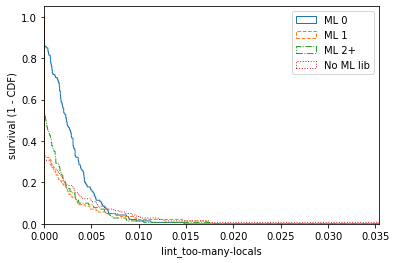

lint_import-error


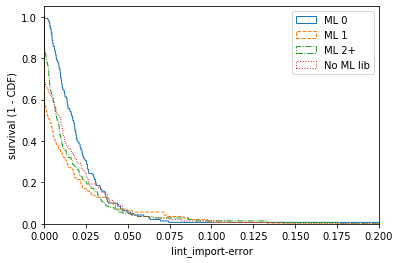

lint_too-many-arguments


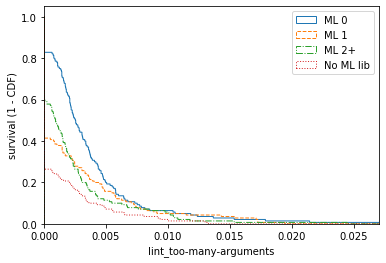

lint_invalid-name


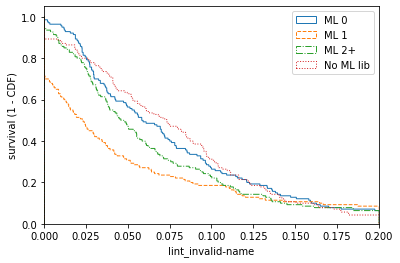

lint_broad-except


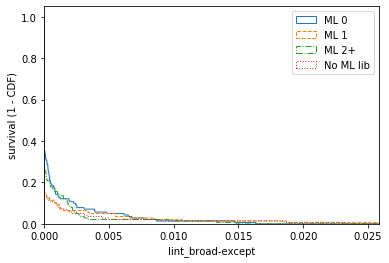

lint_bad-indentation


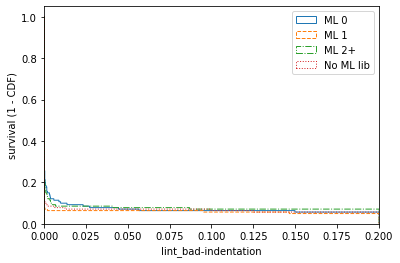

lint_consider-using-enumerate


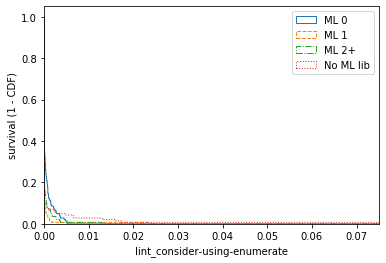

lint_missing-class-docstring


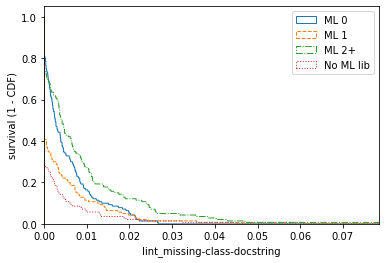

lint_trailing-whitespace


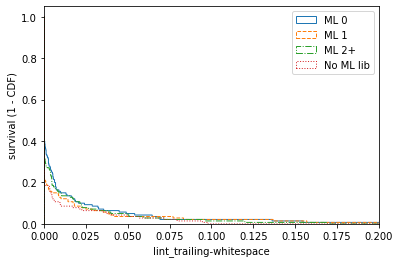

lint_missing-function-docstring


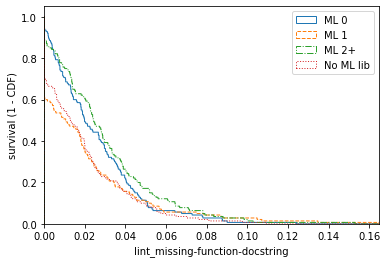

lint_unsubscriptable-object


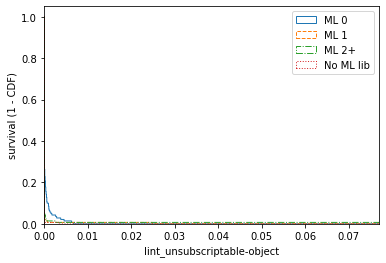

lint_inconsistent-return-statements


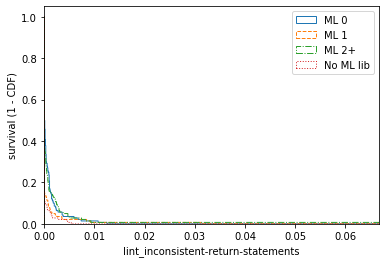

lint_wrong-import-position


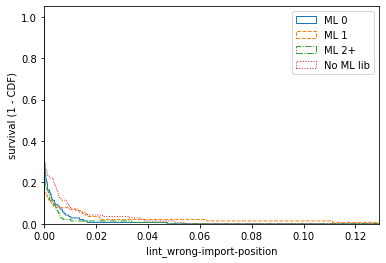

lint_bad-whitespace


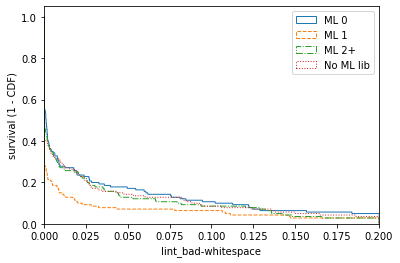

lint_too-many-instance-attributes


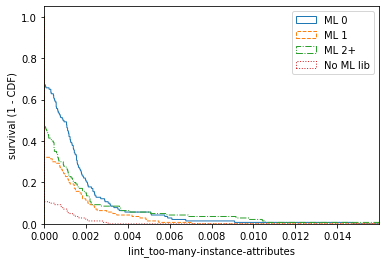

lint_unnecessary-comprehension


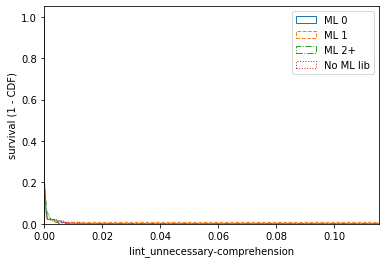

lint_missing-final-newline


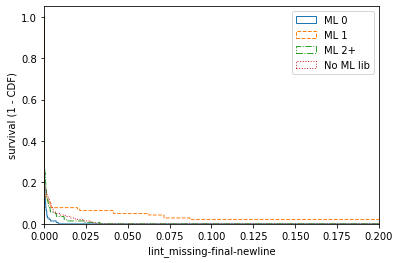

lint_unused-variable


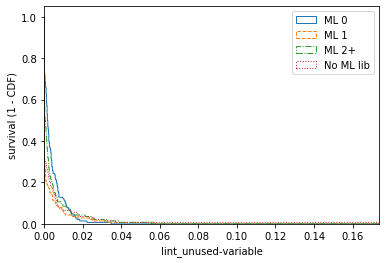

lint_ungrouped-imports


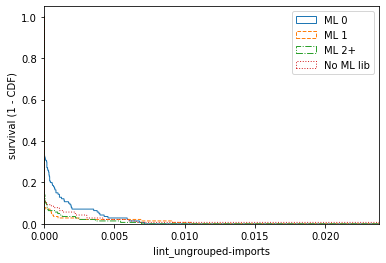

lint_too-few-public-methods


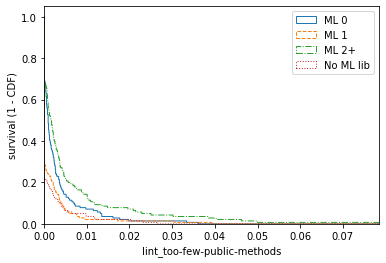

lint_too-many-public-methods


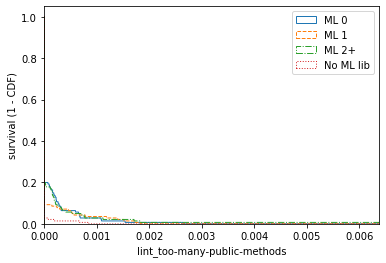

lint_missing-module-docstring


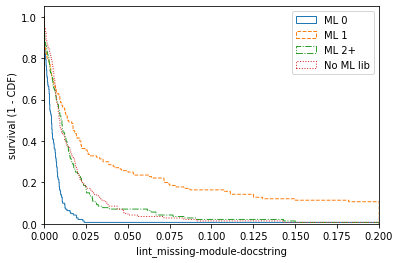

lint_too-many-statements


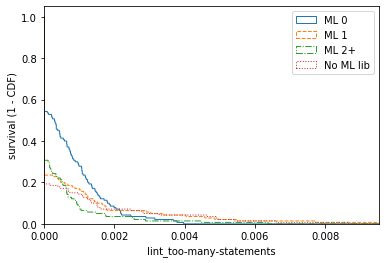

lint_attribute-defined-outside-init


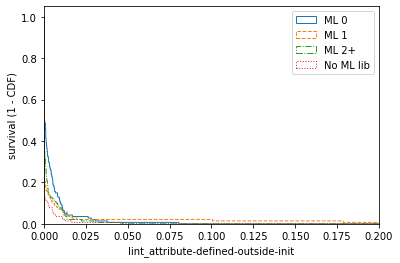

lint_line-too-long


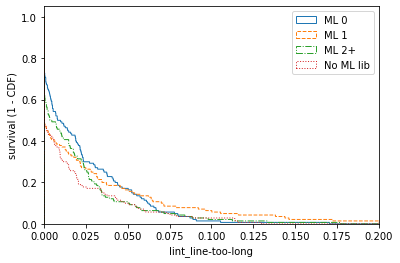

lint_bad-continuation


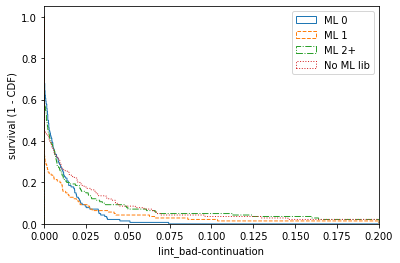

lint_bad-option-value


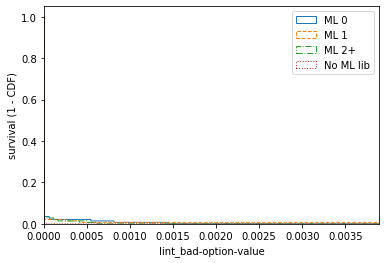

lint_consider-using-dict-comprehension


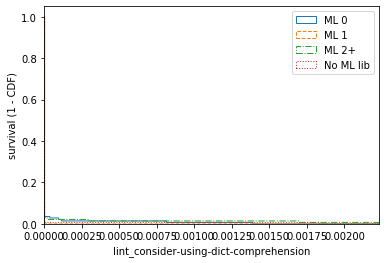

lint_trailing-newlines


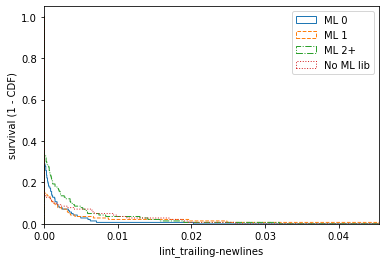

lint_invalid-unary-operand-type


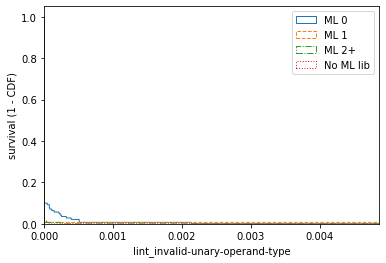

lint_reimported


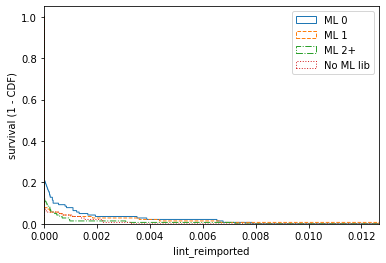

lint_unused-import


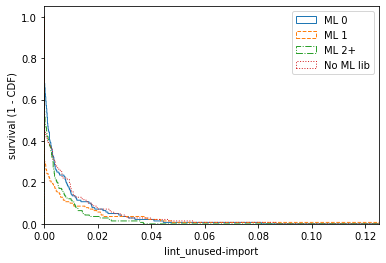

In [71]:
for dim in dims:
    print(dim)
    plot_all_lin_non_mlcats(dim)

In [72]:
# Limit analysis to just ML set
melted_sanitized3_grouped_flat_deeponly_filt = melted_sanitized3_grouped_flat_deeponly[melted_sanitized3_grouped_flat_deeponly["is_ml_repo"] == True]

def plot_all_lin_mlcats(dim, MAX=0.2, note=""):
    rows = melted_sanitized3_grouped_flat_deeponly_filt[melted_sanitized3_grouped_flat_deeponly_filt["variable"] == dim]
    xs1 = rows[rows["cat"] == "ml0"]["normval"]
    xs2 = rows[rows["cat"] == "ml1"]["normval"]
    xs3 = rows[rows["cat"] == "ml2+"]["normval"]
    xs4 = rows[rows["cat"] == "no-ml-dependency"]["normval"]
    #xs5 = rows[rows["cat"] == "test"]["normval"]

    #ks = stats.ks_2samp(xs1, xs2) # calc before any manipulation

    # constrain plot to 0 to 1.0
    xs1 = np.where(xs1 > MAX, MAX, xs1)
    xs2 = np.where(xs2 > MAX, MAX, xs2)
    xs3 = np.where(xs3 > MAX, MAX, xs3)
    xs4 = np.where(xs4 > MAX, MAX, xs4)
    #xs5 = np.where(xs5 > MAX, MAX, xs5)

    start = min(np.min(xs1), np.min(xs2), np.min(xs3), np.min(xs4)) #, np.min(xs5))
    end = max(np.max(xs1), np.max(xs2), np.max(xs3), np.max(xs4)) #, np.max(xs5))
    linbins = np.linspace(start, end+0.001,1000)
    
    plt.hist(xs1, bins=linbins, density=True, histtype='step', cumulative=-1, label='ML 0')
    plt.hist(xs2, bins=linbins, density=True, histtype='step', cumulative=-1, label='ML 1', ls='--')
    plt.hist(xs3, bins=linbins, density=True, histtype='step', cumulative=-1, label='ML 2+', ls='-.')
    plt.hist(xs4, bins=linbins, density=True, histtype='step', cumulative=-1, label='No ML lib', ls=':')
    #plt.hist(xs5, bins=linbins, density=True, histtype='step', cumulative=-1, label='test')

    #plt.title(dim)
    plt.xlabel(dim)
    plt.xlim(start, end)
    plt.ylabel('survival (1 - CDF)')
    plt.legend(loc='upper right')
    plt.savefig(join(NB_OUT, dim + note + '-modules-cdf-cutoff.png'), dpi=300)
    plt.show()

In [73]:
len(melted_sanitized3_grouped_flat_deeponly_filt.repo.unique())

263

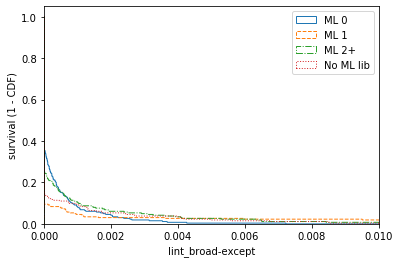

In [74]:
plot_all_lin_mlcats("lint_broad-except", 0.01, "-cropped")

lint_too-many-locals


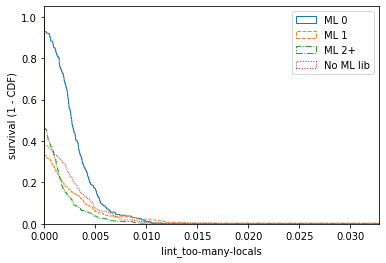

lint_import-error


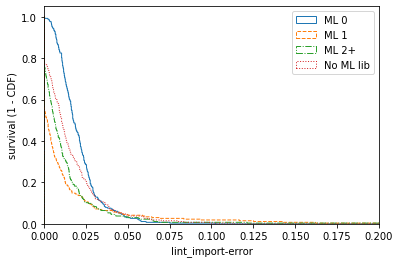

lint_too-many-arguments


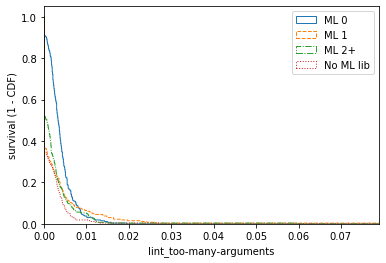

lint_invalid-name


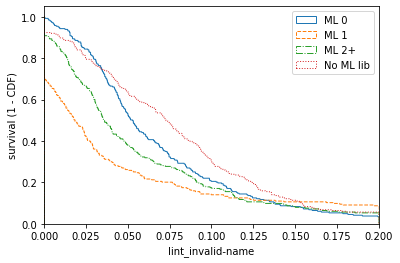

lint_broad-except


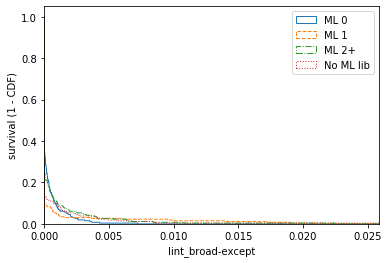

lint_bad-indentation


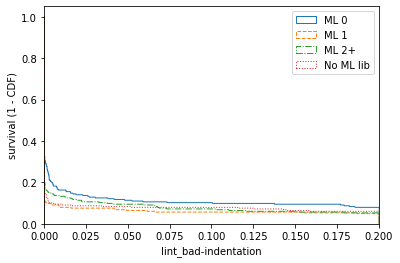

lint_consider-using-enumerate


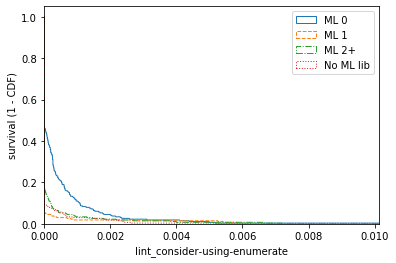

lint_missing-class-docstring


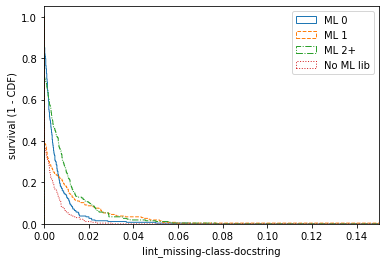

lint_trailing-whitespace


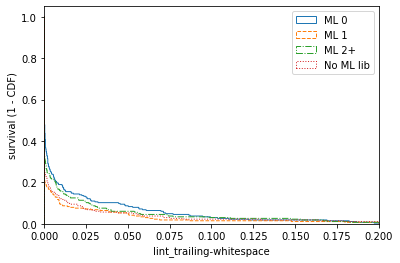

lint_missing-function-docstring


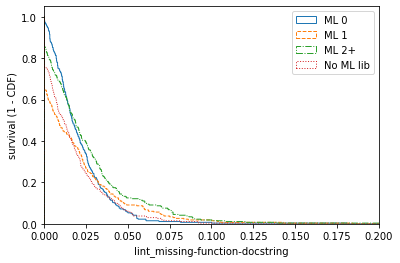

lint_unsubscriptable-object


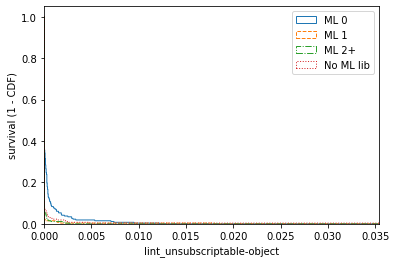

lint_inconsistent-return-statements


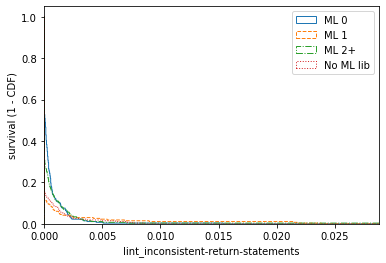

lint_wrong-import-position


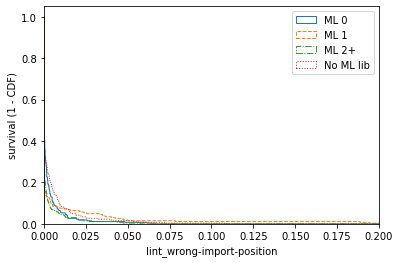

lint_bad-whitespace


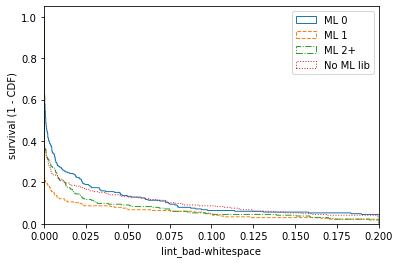

lint_too-many-instance-attributes


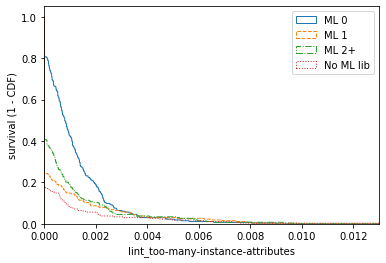

lint_unnecessary-comprehension


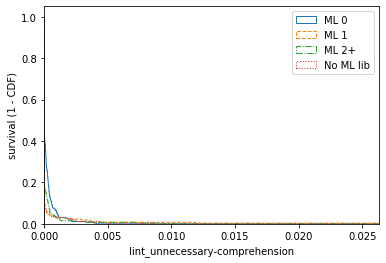

lint_missing-final-newline


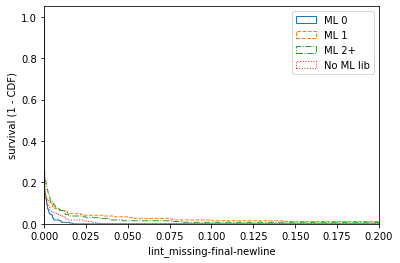

lint_unused-variable


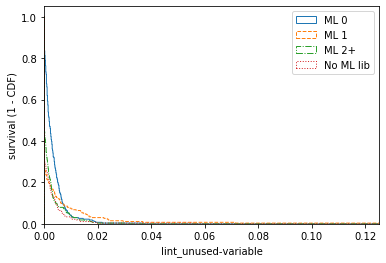

lint_ungrouped-imports


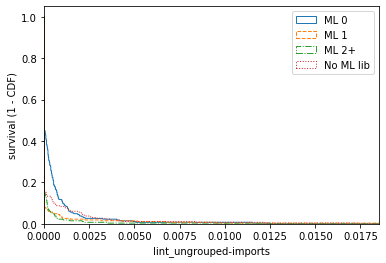

lint_too-few-public-methods


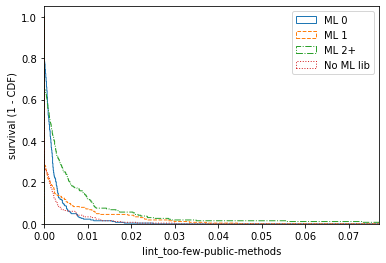

lint_too-many-public-methods


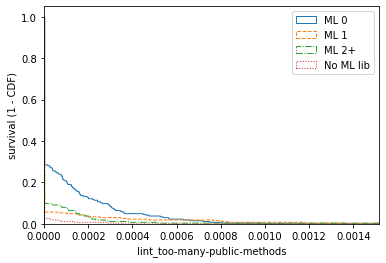

lint_missing-module-docstring


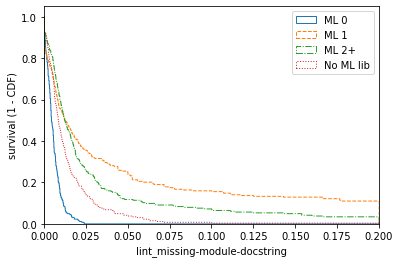

lint_too-many-statements


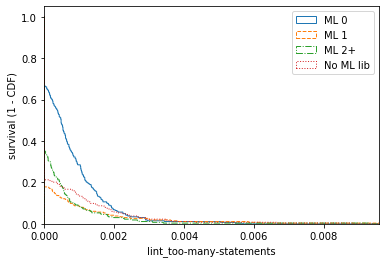

lint_attribute-defined-outside-init


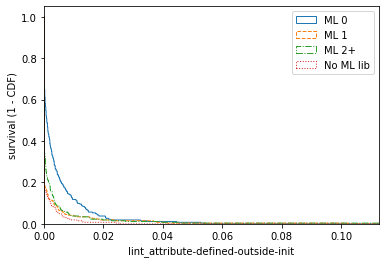

lint_line-too-long


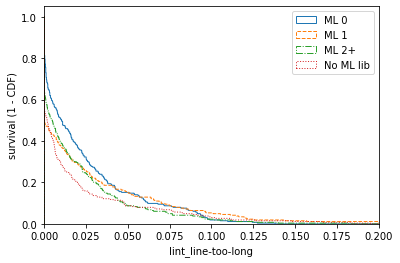

lint_bad-continuation


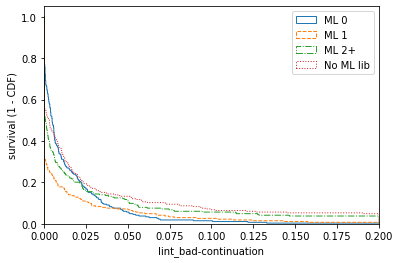

lint_bad-option-value


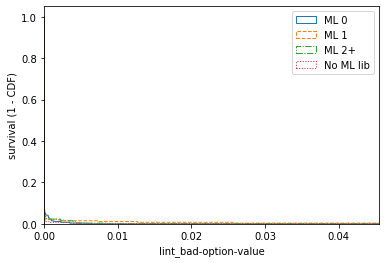

lint_consider-using-dict-comprehension


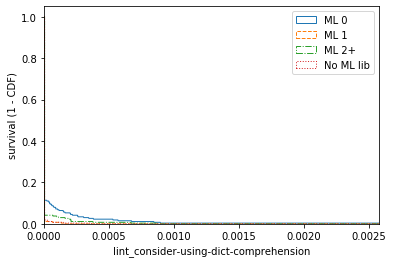

lint_trailing-newlines


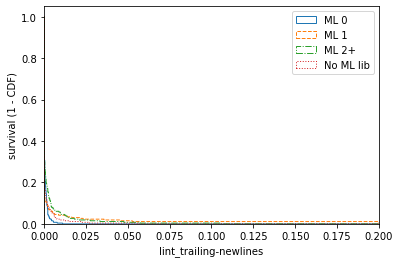

lint_invalid-unary-operand-type


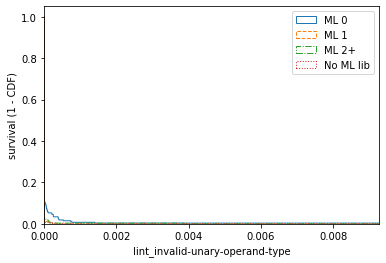

lint_reimported


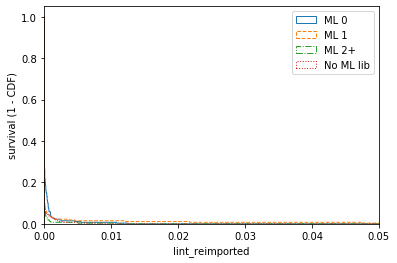

lint_unused-import


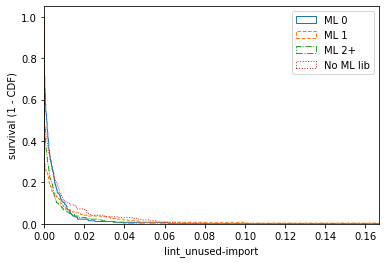

In [75]:
for dim in dims:
    print(dim)
    plot_all_lin_mlcats(dim)

### Exploration of differences in Pylint warnings for each category (repo basis)

This section groups the data by repo prior to visualisation (e.g. repo 21467110). The entire repo is marked as ML or non-ML (based on the fraction of ML modules in the repo).

In [76]:
melted_sanitized3_grouped_repo = melted_sanitized3.groupby(["repo", "is_ml_repo", "variable"]).sum()
melted_sanitized3_grouped_repo["normval"] = melted_sanitized3_grouped_repo["value"] / melted_sanitized3_grouped_repo["loc"]
melted_sanitized3_grouped_repoflat = pd.DataFrame(melted_sanitized3_grouped_repo.to_records())

In [77]:
melted_sanitized3_grouped_repoflat

,repo,is_ml_repo,variable,loc,value,normval
0,192904,True,lint_abstract-class-instantiated,43064.0,0.0,0.000000
1,192904,True,lint_abstract-method,43064.0,28.0,0.000650
2,192904,True,lint_access-member-before-definition,43064.0,0.0,0.000000
3,192904,True,lint_anomalous-backslash-in-string,43064.0,30.0,0.000697
4,192904,True,lint_anomalous-unicode-escape-in-string,43064.0,0.0,0.000000
...,...,...,...,...,...,...
491658,234515221,False,lint_using-constant-test,8495.0,0.0,0.000000
491659,234515221,False,lint_wildcard-import,8495.0,0.0,0.000000
491660,234515221,False,lint_wrong-exception-operation,8495.0,0.0,0.000000
491661,234515221,False,lint_wrong-import-order,8495.0,53.0,0.006239


In [78]:
len(melted_sanitized3_grouped_repoflat[melted_sanitized3_grouped_repoflat["is_ml_repo"] == True].repo.unique())

1048

In [79]:
len(melted_sanitized3_grouped_repoflat[melted_sanitized3_grouped_repoflat["is_ml_repo"] == False].repo.unique())

1099

In [80]:
melted_sanitized3_grouped_repoflat["normval"].describe() # Why can this be > 100%? (because multiple violations per line)

count    491663.000000
mean          0.001821
std           0.023552
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.909806
Name: normval, dtype: float64

In [81]:
def plot_all_lin_cmp(dim):
    rows = melted_sanitized3_grouped_repoflat[melted_sanitized3_grouped_repoflat["variable"] == dim]
    xs1 = rows[rows["is_ml_repo"] == True]["normval"]
    xs2 = rows[rows["is_ml_repo"] == False]["normval"]
    ks = stats.ks_2samp(xs1, xs2) # calc before any manipulation

    # constrain plot to 0 to 1.0
    MAX = 0.2
    xs1 = np.where(xs1 > MAX, MAX, xs1)
    xs2 = np.where(xs2 > MAX, MAX, xs2)

    start = min(np.min(xs1), np.min(xs2))
    end = (max(np.max(xs1), np.max(xs2)))
    linbins = np.linspace(start, end+0.001,1000)
    
    plt.hist(xs1, bins=linbins, density=True, histtype='step', cumulative=-1, label='ds')
    plt.hist(xs2, bins=linbins, density=True, histtype='step', cumulative=-1, label='non-ds', ls='--')
    #plt.title(dim)
    plt.xlabel(dim)
    plt.xlim(start, end)
    plt.ylabel('survival (1 - CDF)')
    plt.legend(loc='upper right')
    plt.savefig(join(NB_OUT, dim + '-cdf-cutoff.png'), dpi=300)
    plt.show()
    
    return ks

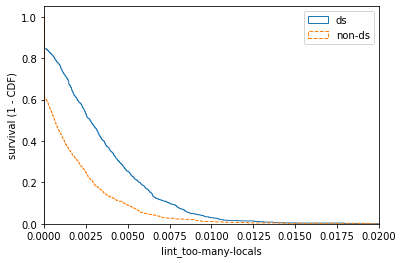

Ks_2sampResult(statistic=0.3303992526168828, pvalue=2.728944550636899e-51)


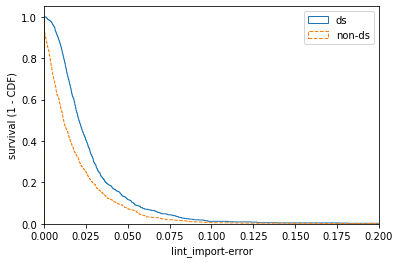

Ks_2sampResult(statistic=0.30981669664997324, pvalue=3.766827880517726e-45)


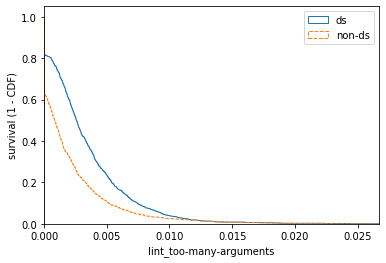

Ks_2sampResult(statistic=0.30783276260861714, pvalue=1.40262685844063e-44)


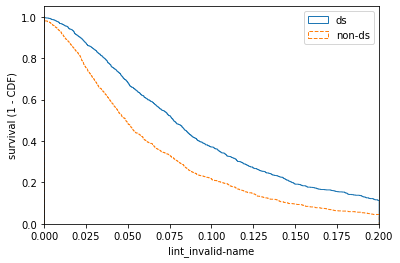

Ks_2sampResult(statistic=0.20976738047774174, pvalue=6.281197875929032e-21)


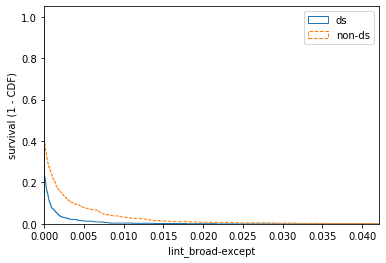

Ks_2sampResult(statistic=0.16789378268932895, pvalue=1.1013412404281553e-13)


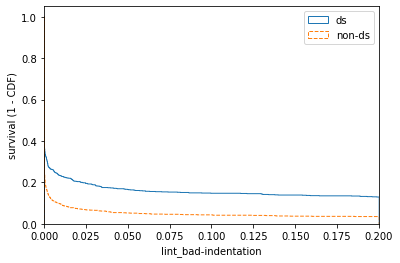

Ks_2sampResult(statistic=0.15323003563267093, pvalue=1.8236301357887896e-11)


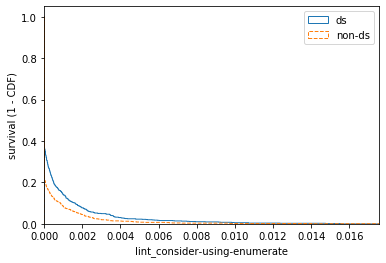

Ks_2sampResult(statistic=0.15040737936639137, pvalue=4.6172177192715935e-11)


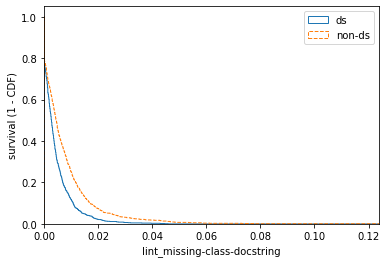

Ks_2sampResult(statistic=0.17842295910925268, pvalue=1.6653345369377348e-15)


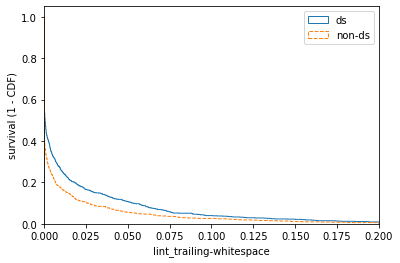

Ks_2sampResult(statistic=0.1534010793990373, pvalue=1.7248424910576432e-11)


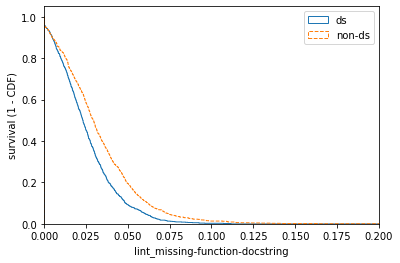

Ks_2sampResult(statistic=0.14576575512784, pvalue=2.0485846352613635e-10)


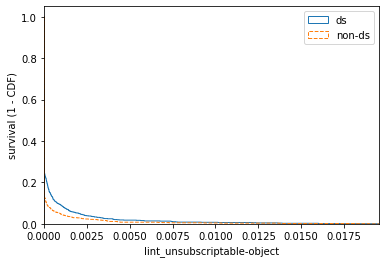

Ks_2sampResult(statistic=0.1161977578506484, pvalue=8.952146461904675e-07)


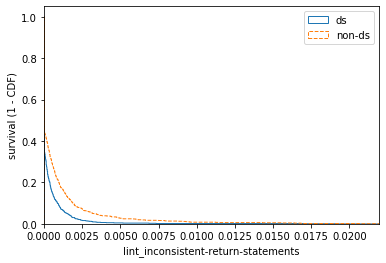

Ks_2sampResult(statistic=0.14629277830644097, pvalue=1.7338930291543875e-10)


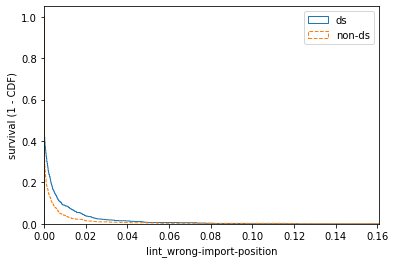

Ks_2sampResult(statistic=0.1305220221019803, pvalue=1.9573190290778086e-08)


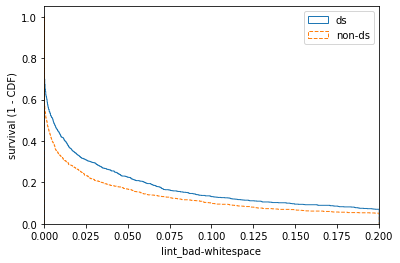

Ks_2sampResult(statistic=0.1321256659419736, pvalue=1.2411096150799494e-08)


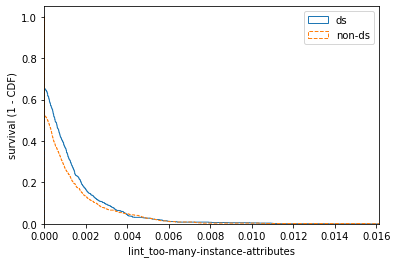

Ks_2sampResult(statistic=0.13211003757753406, pvalue=1.246989211889371e-08)


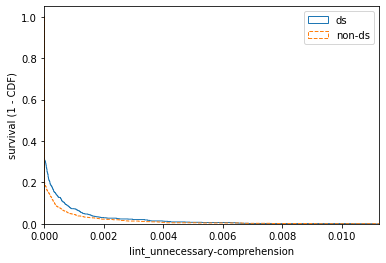

Ks_2sampResult(statistic=0.11590342365370322, pvalue=9.637266957795987e-07)


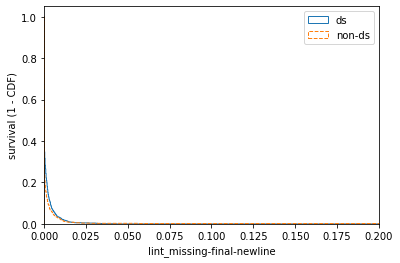

Ks_2sampResult(statistic=0.11729174336141808, pvalue=6.79095247702044e-07)


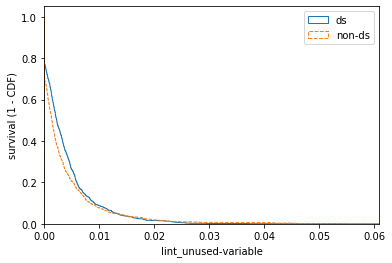

Ks_2sampResult(statistic=0.12701779549764186, pvalue=5.2000452166467426e-08)


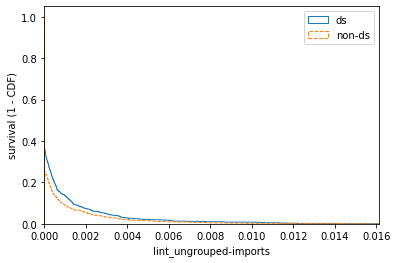

Ks_2sampResult(statistic=0.10963818599837465, pvalue=4.4402113800190435e-06)


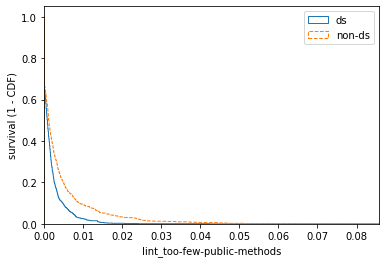

Ks_2sampResult(statistic=0.14092617160638748, pvalue=9.206277962192644e-10)


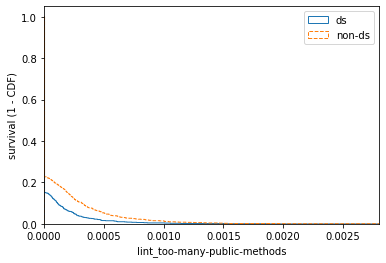

Ks_2sampResult(statistic=0.09668140363550487, pvalue=7.980553642072952e-05)


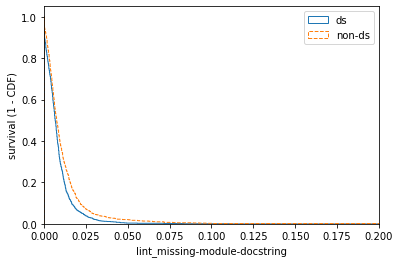

Ks_2sampResult(statistic=0.10594641902076142, pvalue=1.049502531613733e-05)


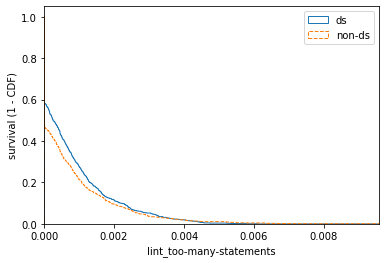

Ks_2sampResult(statistic=0.11964554869451062, pvalue=3.717258640900667e-07)


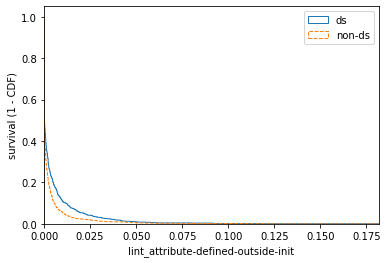

Ks_2sampResult(statistic=0.09289847119866082, pvalue=0.00017325125719280798)


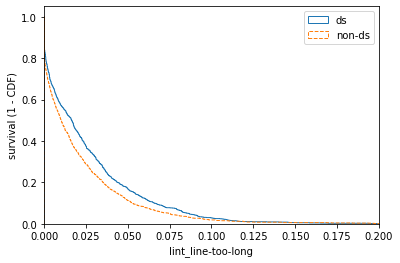

Ks_2sampResult(statistic=0.11208489327563573, pvalue=2.471120298275231e-06)


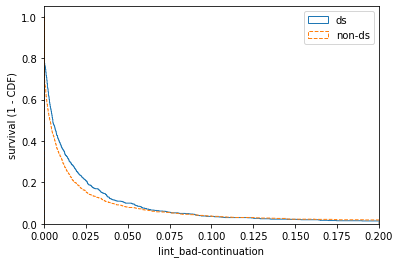

Ks_2sampResult(statistic=0.11179750501844148, pvalue=2.6485750034277444e-06)


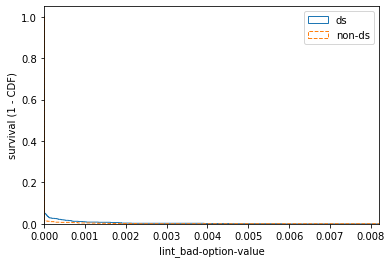

Ks_2sampResult(statistic=0.03519247199049796, pvalue=0.5042001452456902)


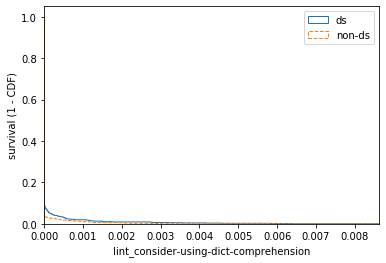

Ks_2sampResult(statistic=0.04874834165688447, pvalue=0.14930782158532585)


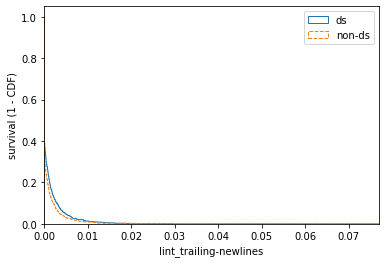

Ks_2sampResult(statistic=0.08442181997513354, pvalue=0.0008789678194887074)


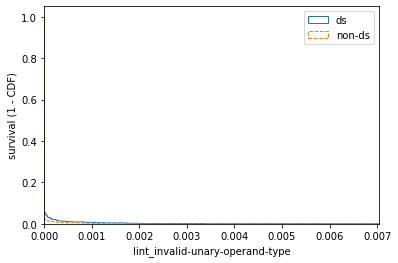

Ks_2sampResult(statistic=0.03363831797122992, pvalue=0.5622962553891654)


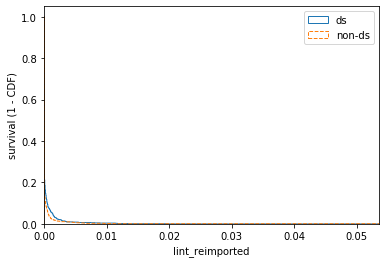

Ks_2sampResult(statistic=0.07048479186491537, pvalue=0.009058527294672825)


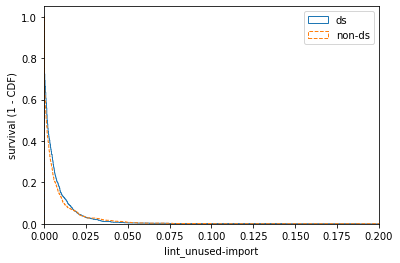

Ks_2sampResult(statistic=0.08595426793267995, pvalue=0.0006630067403030626)


In [82]:
for dim in dims:
    print(plot_all_lin_cmp(dim))

In [83]:
melted_sanitized3_grouped_repoflat

,repo,is_ml_repo,variable,loc,value,normval
0,192904,True,lint_abstract-class-instantiated,43064.0,0.0,0.000000
1,192904,True,lint_abstract-method,43064.0,28.0,0.000650
2,192904,True,lint_access-member-before-definition,43064.0,0.0,0.000000
3,192904,True,lint_anomalous-backslash-in-string,43064.0,30.0,0.000697
4,192904,True,lint_anomalous-unicode-escape-in-string,43064.0,0.0,0.000000
...,...,...,...,...,...,...
491658,234515221,False,lint_using-constant-test,8495.0,0.0,0.000000
491659,234515221,False,lint_wildcard-import,8495.0,0.0,0.000000
491660,234515221,False,lint_wrong-exception-operation,8495.0,0.0,0.000000
491661,234515221,False,lint_wrong-import-order,8495.0,53.0,0.006239


## Which differences between ML repos and non-ML repos are statistically significant?

In [84]:
def one_way_test(a, b, rowname="row"):
    meana = np.mean(a)
    meda = np.median(a)
    stda = np.std(a, ddof=1) # sample SD
    meanb = np.mean(b)
    medb = np.median(b)
    stdb = np.std(b, ddof=1) # sample SD
    # f-test (one-way ANOVA)
    f_stat, f_pval = stats.f_oneway(a, b)
    # kruskal (non-parametric equivalent to the ANOVA testing difference of median)
    try:
        k_stat, k_pval = stats.kruskal(a, b)
    except ValueError as e:
        print("WARN: Row {}: {}".format(rowname, str(e)))
        k_stat, k_pval = (np.nan, np.nan)
    # mannwhitneyu (rank test on independent samples)
    # Disclaimer: "Use only when the number of observation in each sample is > 20"
    try:
        u_stat, u_pval = stats.mannwhitneyu(a, b, alternative='two-sided')
    except ValueError as e:
        print("WARN: Row {}: {}".format(rowname, str(e)))
        u_stat, u_pval = (np.nan, np.nan)
    # TODO: consider Fisher's exact test on errors-vs-non-errors
    
    return [rowname, meana, meda, stda, meanb, medb, stdb, f_stat, f_pval, k_stat, k_pval, u_stat, u_pval]

In [85]:
melted_sanitized3_grouped_repoflat_filled = melted_sanitized3_grouped_repoflat.fillna(0)

In [86]:
melted_sanitized3_grouped_repoflat_filled

,repo,is_ml_repo,variable,loc,value,normval
0,192904,True,lint_abstract-class-instantiated,43064.0,0.0,0.000000
1,192904,True,lint_abstract-method,43064.0,28.0,0.000650
2,192904,True,lint_access-member-before-definition,43064.0,0.0,0.000000
3,192904,True,lint_anomalous-backslash-in-string,43064.0,30.0,0.000697
4,192904,True,lint_anomalous-unicode-escape-in-string,43064.0,0.0,0.000000
...,...,...,...,...,...,...
491658,234515221,False,lint_using-constant-test,8495.0,0.0,0.000000
491659,234515221,False,lint_wildcard-import,8495.0,0.0,0.000000
491660,234515221,False,lint_wrong-exception-operation,8495.0,0.0,0.000000
491661,234515221,False,lint_wrong-import-order,8495.0,53.0,0.006239


In [87]:
rows = []
for factor, factor_data in melted_sanitized3_grouped_repoflat_filled.groupby("variable"):
    a = factor_data["normval"][(factor_data["is_ml_repo"] == True)]
    b = factor_data["normval"][(factor_data["is_ml_repo"] == False)]
    row = one_way_test(a, b, rowname=factor)
    rows.append(row)

Comparison of factors (lint errrors), after normalizing for LOC

In [88]:
df = pd.DataFrame.from_records(rows, columns=["factor", "meana", "meda", "stda", "meanb", "medb", "stdb", "f_stat", "f_pval", "k_stat", "k_pval", "u_stat", "u_pval"])

In [89]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [90]:
df = df.sort_values("u_pval")
df

,factor,meana,meda,stda,meanb,medb,stdb,f_stat,f_pval,k_stat,k_pval,u_stat,u_pval
181,lint_too-many-locals,3.356140e-03,0.002750,3.016431e-03,1.619029e-03,0.000631,2.390386e-03,219.756013,2.089651e-47,265.468189,1.103134e-59,807392.5,1.103769e-59
73,lint_import-error,2.727872e-02,0.020722,2.375512e-02,1.826193e-02,0.011561,2.203306e-02,83.242632,1.625310e-19,200.071215,2.015075e-45,778965.5,2.016073e-45
174,lint_too-many-arguments,3.322336e-03,0.002572,3.262792e-03,1.899302e-03,0.000829,2.898737e-03,114.378523,4.817937e-26,185.456668,3.119637e-42,769245.0,3.121142e-42
83,lint_invalid-name,9.881936e-02,0.077309,8.003947e-02,6.938472e-02,0.048602,6.958596e-02,82.911916,1.909348e-19,113.983424,1.314024e-26,729170.5,1.314517e-26
33,lint_broad-except,3.304842e-04,0.000000,1.354159e-03,1.337286e-03,0.000000,3.806245e-03,65.427343,9.980264e-16,82.831438,8.935741e-20,467222.5,8.939188e-20
19,lint_bad-indentation,6.577049e-02,0.000000,1.624634e-01,2.242144e-02,0.000000,1.045030e-01,54.567397,2.139490e-13,59.495910,1.225485e-14,667876.0,1.225888e-14
46,lint_consider-using-enumerate,5.373928e-04,0.000000,1.548811e-03,2.896536e-04,0.000000,1.093931e-03,18.460907,1.811719e-05,56.052983,7.054408e-14,661938.5,7.056746e-14
104,lint_missing-class-docstring,4.287337e-03,0.002647,5.579042e-03,7.265643e-03,0.004435,9.898073e-03,72.822136,2.640071e-17,51.792329,6.169238e-13,473090.0,6.170821e-13
188,lint_trailing-whitespace,1.585483e-02,0.000524,3.708405e-02,1.045393e-02,0.000000,3.865897e-02,10.894740,9.801815e-04,50.142335,1.429886e-12,671068.0,1.430270e-12
108,lint_missing-function-docstring,2.562994e-02,0.023134,1.793950e-02,3.262897e-02,0.029412,2.374694e-02,58.953650,2.435514e-14,47.323725,6.017940e-12,477105.0,6.019411e-12


In [91]:
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")

In [92]:
df.to_csv(join(NB_OUT, "pylint_ml_significance.csv"))